# Selecting Best Classical ML Model for Analysis of DermaMNIST Dataset

This notebook is designed to run entirely in Google Colab without requiring local dataset downloads, using Colab's computational resources.


---



This project implements a pipeline for image classification using classical machine learning approaches on the DermaMNIST dataset.

**The workflow includes:**    

1. **Data Preparation**: Loading and preprocessing the DermaMNIST dataset containing dermatological images across 7 different skin conditions.

2. **Feature Engineering**: Extracting three types of complementary features:
   - Color features (RGB/HSV histograms, color moments, color correlograms)
   - Texture features (Local Binary Patterns, Histogram of Oriented Gradients)
   - Shape features (contour statistics, Hu moments)

3. **Feature Processing**: Preventing data leakage through proper train/test separation, applying standardization, variance thresholding, and feature selection.

4. **Model Evaluation**: Comparing five classical machine learning algorithms:
   - Logistic Regression with L1/L2 regularization
   - Random Forest with optimized depth/leaf parameters
   - XGBoost with regularization techniques
   - Support Vector Machines with various kernels
   - Extra Trees ensemble

5. **Performance Analysis**: Evaluating models using accuracy, precision, recall, and F1 score with careful analysis of training-test gaps to assess generalization.

The notebook includes error handling, parallel processing and a cross-validation to ensure reliable model selection while preventing overfitting.

In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.3 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha25

In [ ]:
# CELL 0
# Imports

# ========== Standard Libraries ==========
import os
import platform
import time
from datetime import datetime
from itertools import cycle
from functools import partial
import multiprocessing
from multiprocessing import Pool, cpu_count

# ========== PyTorch and Torchvision ==========
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

# ========== Scientific Computing ==========
import numpy as np
import pandas as pd
from scipy.stats import skew

# ========== Plotting ==========
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

# ========== Progress Bar ==========
from tqdm.notebook import tqdm

# ========== Image Processing ==========
import cv2
from PIL import Image
from skimage import color
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog

# ========== MedMNIST Dataset ==========
import medmnist
from medmnist import INFO, DermaMNIST

# ========== Machine Learning: Scikit-learn ==========
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    average_precision_score, confusion_matrix,
    f1_score, classification_report, accuracy_score,
    precision_score, recall_score
)
from sklearn.model_selection import cross_validate, KFold, RandomizedSearchCV
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# ========== Other ML Libraries ==========
from xgboost import XGBClassifier

# ========== Utilities ==========
import joblib
import traceback


In [ ]:
# CELL 1
# Computational info

# Record start time
notebook_start_time = time.time()

# Get system info
system_info = {
    'platform': platform.platform(),
    'python_version': platform.python_version(),
    'date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

# Get GPU information if available
if torch.cuda.is_available():
    gpu_info = {
        'device_name': torch.cuda.get_device_name(0),
        'device_count': torch.cuda.device_count(),
        'cuda_version': torch.version.cuda,
    }
    print(f"Using GPU: {gpu_info['device_name']}")
else:
    gpu_info = {'device_name': 'CPU (No GPU available)'}
    print("Using CPU (No GPU available)")

print(f"System: {system_info['platform']}")
print(f"Python: {system_info['python_version']}")
print(f"PyTorch: {torch.__version__}")
print(f"Start time: {system_info['date']}")

cpu_info = {
    'cpu_count': multiprocessing.cpu_count(),
    'processor': platform.processor()
}
print(f"CPU: {cpu_info['processor']}")
print(f"CPU Cores: {cpu_info['cpu_count']}")

Using GPU: NVIDIA L4
System: Linux-6.1.123+-x86_64-with-glibc2.35
Python: 3.11.12
PyTorch: 2.6.0+cu124
Start time: 2025-05-12 10:19:10
CPU: x86_64
CPU Cores: 12


In [ ]:
#CELL 2
# Load the dataset and create data loaders

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset: loading, preprocessing, transformations
print("Loading DermaMNIST dataset...")
train_dataset = DermaMNIST(split='train', download=True, size=224)
val_dataset = DermaMNIST(split='val', download=True, size=224)
test_dataset = DermaMNIST(split='test', download=True, size=224)

# Get dataset info
data_info = INFO['dermamnist']
num_classes = len(data_info['label'])
print(f"Task: {data_info['task']}")
print(f"Number of classes: {num_classes}")
print(f"Train/Val/Test: {len(train_dataset)}/{len(val_dataset)}/{len(test_dataset)} images")

# Define image transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataloaders: batch creation, wrappers
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        # Convert NumPy array to torch tensor before calling long()
        if isinstance(label, np.ndarray):
            label = torch.tensor(label)
        return image, label.squeeze().long()

# Create transformed datasets
train_dataset_transformed = TransformDataset(train_dataset, transform=train_transform)
val_dataset_transformed = TransformDataset(val_dataset, transform=val_transform)
test_dataset_transformed = TransformDataset(test_dataset, transform=val_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset_transformed, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset_transformed, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset_transformed, batch_size=batch_size, shuffle=False, num_workers=2)

Using device: cuda
Loading DermaMNIST dataset...


100%|██████████| 1.09G/1.09G [01:48<00:00, 10.0MB/s]


Task: multi-class
Number of classes: 7
Train/Val/Test: 7007/1003/2005 images


Standardized 7 class names
Checking for data quality issues...
Checking train dataset with 7007 samples


Checking train:   0%|          | 0/7007 [00:00<?, ?it/s]

Found 0 corrupt images and 0 blank images in train
Checking validation dataset with 1003 samples


Checking validation:   0%|          | 0/1003 [00:00<?, ?it/s]

Found 0 corrupt images and 0 blank images in validation
Checking test dataset with 2005 samples


Checking test:   0%|          | 0/2005 [00:00<?, ?it/s]

Found 0 corrupt images and 0 blank images in test
Corrupt images: Train=0, Val=0, Test=0
Zero/One value images: Train=0, Val=0, Test=0


Class names structure: <class 'dict'>
Class names content: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}


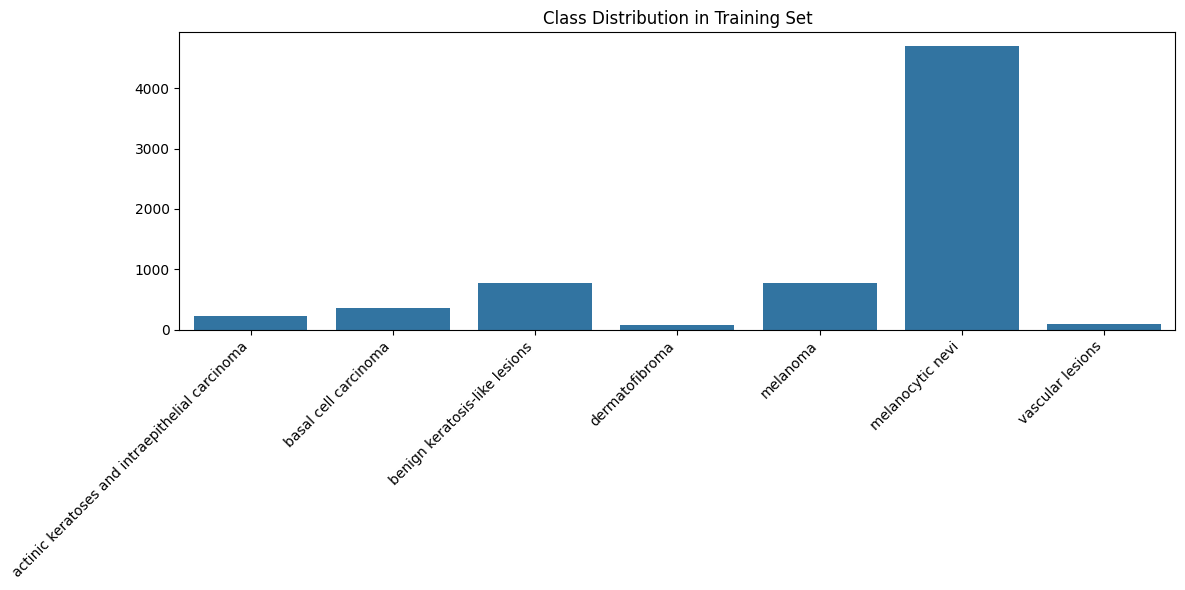

Class weights to handle imbalance: tensor([ 4.3904,  2.7883,  1.3017, 12.5125,  1.2850,  0.2133, 10.1111])


Calculating dataset stats:   0%|          | 0/71 [00:00<?, ?it/s]

Calculated dataset mean: tensor([1.1081, 0.1882, 0.4918]), std: tensor([0.3963, 0.5516, 0.6148])
Using normalization mean: [0.485, 0.456, 0.406], std: [0.229, 0.224, 0.225]


Created balanced dataloader with 219 batches
Data preparation complete. Ready for model training.


In [ ]:
# CELL 3
# Data Preparation
try:
    class_names = data_info['label']
    if not isinstance(class_names, dict):
        class_names = {str(i): name for i, name in enumerate(class_names)}
    print(f"Standardized {len(class_names)} class names")
except Exception as e:
    print(f"Error standardizing class names: {str(e)}")
    # Create default class names as fallback
    class_names = {str(i): f"Class {i}" for i in range(7)}  # DermaMNIST has 7 classes

# Helper function with class name handling
def get_class_label(idx):
    """
    Get class label from standardized class_names dictionary.

    Args:
        idx: Class index

    Returns:
        Class label as string
    """
    try:
        idx_str = str(idx)
        return class_names[idx_str] if idx_str in class_names else f"Class {idx}"
    except Exception as e:
        print(f"Error getting class label for index {idx}: {str(e)}")
        return f"Class {idx}"

# 1. Check for missing/corrupted data
print("Checking for data quality issues...")
missing_data = {'train': 0, 'val': 0, 'test': 0}

# Function to check for potential data issues
def check_dataset_quality(dataset, name="dataset"):
    """Check dataset for corrupted images or anomalies with detailed error logging"""
    corrupt_indices = []
    zero_pixel_count = 0
    error_count = 0

    print(f"Checking {name} dataset with {len(dataset)} samples")
    for i in tqdm(range(len(dataset)), desc=f"Checking {name}"):
        try:
            img, label = dataset[i]

            # Verify image is a tensor
            if not isinstance(img, torch.Tensor):
                print(f"Warning: Image {i} is not a tensor, type: {type(img)}")

            # Check for completely black or white images
            if isinstance(img, torch.Tensor) and (torch.all(img == 0) or torch.all(img == 1)):
                zero_pixel_count += 1
                print(f"Warning: Image {i} is all zeros or ones")

            # Check for NaN values
            if isinstance(img, torch.Tensor) and torch.isnan(img).any():
                print(f"Warning: Image {i} contains NaN values")
                corrupt_indices.append(i)

            # Check for invalid labels
            if isinstance(label, torch.Tensor):
                label_value = label.item() if label.numel() == 1 else label.numpy()
            else:
                label_value = label

            if not isinstance(label_value, (int, np.integer)) or label_value < 0 or label_value >= len(class_names):
                print(f"Warning: Image {i} has invalid label: {label_value}")
                corrupt_indices.append(i)

        except Exception as e:
            error_count += 1
            corrupt_indices.append(i)
            print(f"Error processing image {i}: {str(e)}")

            # Log detailed error info for the first few errors
            if error_count <= 5:
                traceback_info = traceback.format_exc()
                print(f"Traceback: {traceback_info}")

    print(f"Found {len(corrupt_indices)} corrupt images and {zero_pixel_count} blank images in {name}")
    return corrupt_indices, zero_pixel_count

# Check each dataset
try:
    train_corrupt, train_zero = check_dataset_quality(train_dataset_transformed, "train")
    val_corrupt, val_zero = check_dataset_quality(val_dataset_transformed, "validation")
    test_corrupt, test_zero = check_dataset_quality(test_dataset_transformed, "test")

    print(f"Corrupt images: Train={len(train_corrupt)}, Val={len(val_corrupt)}, Test={len(test_corrupt)}")
    print(f"Zero/One value images: Train={train_zero}, Val={val_zero}, Test={test_zero}")
except Exception as e:
    print(f"Failed to check dataset quality: {str(e)}")
    traceback_info = traceback.format_exc()
    print(f"Traceback: {traceback_info}")

# 2. Analyze class distribution
try:
    train_labels = []
    for _, label in tqdm(train_loader.dataset, desc="Collecting labels"):
        try:
            if isinstance(label, torch.Tensor):
                label_value = label.item() if label.numel() == 1 else int(label[0])
            else:
                label_value = int(label)
            train_labels.append(label_value)
        except Exception as e:
            print(f"Error converting label {label}: {str(e)}")

    class_counts = np.bincount(train_labels, minlength=len(class_names))

    # Print class names structure
    print("Class names structure:", type(class_names))
    print("Class names content:", class_names)

    # Display class distribution using standardized function
    plt.figure(figsize=(12, 6))
    class_labels = [get_class_label(i) for i in range(len(class_counts))]

    sns.barplot(x=class_labels, y=class_counts)
    plt.title('Class Distribution in Training Set')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Failed to analyze class distribution: {str(e)}")
    traceback_info = traceback.format_exc()
    print(f"Traceback: {traceback_info}")
    # Create default class counts as fallback
    class_counts = np.ones(len(class_names), dtype=int)

# Calculate class weights for handling imbalance
try:
    class_weights = torch.FloatTensor(len(class_counts))
    for i in range(len(class_counts)):
        if class_counts[i] > 0:
            class_weights[i] = len(train_labels) / (class_counts[i] * len(class_counts))
        else:
            class_weights[i] = 1.0
            print(f"Warning: Class {i} has zero samples, setting weight to 1.0")

    print("Class weights to handle imbalance:", class_weights)
except Exception as e:
    print(f"Failed to calculate class weights: {str(e)}")
    # Default to balanced class weights
    class_weights = torch.ones(len(class_names), dtype=torch.float32)

# 3. Verify normalization parameters
# Calculate actual mean and std from a sample of training data
def get_mean_std(loader):
    try:
        mean = 0.
        std = 0.
        total_samples = 0
        for images, _ in tqdm(loader, desc="Calculating dataset stats"):
            try:
                batch_samples = images.size(0)
                images = images.view(batch_samples, images.size(1), -1)
                mean += images.mean(2).sum(0)
                std += images.std(2).sum(0)
                total_samples += batch_samples
            except Exception as e:
                print(f"Error processing batch: {str(e)}")

        if total_samples > 0:
            mean /= total_samples
            std /= total_samples
            return mean, std
        else:
            print("No samples processed, returning default values")
            return torch.tensor([0.5, 0.5, 0.5]), torch.tensor([0.5, 0.5, 0.5])
    except Exception as e:
        print(f"Failed to calculate mean and std: {str(e)}")
        return torch.tensor([0.5, 0.5, 0.5]), torch.tensor([0.5, 0.5, 0.5])

try:
    sample_loader = DataLoader(train_dataset_transformed, batch_size=100, shuffle=False, num_workers=2)
    calculated_mean, calculated_std = get_mean_std(sample_loader)
    print(f"Calculated dataset mean: {calculated_mean}, std: {calculated_std}")
    print(f"Using normalization mean: [0.485, 0.456, 0.406], std: [0.229, 0.224, 0.225]")
except Exception as e:
    print(f"Failed to create sample loader: {str(e)}")

# Create weighted sampler for handling class imbalance
try:
    train_indices = list(range(len(train_dataset_transformed)))
    train_targets = []

    for i in tqdm(train_indices, desc="Collecting targets"):
        try:
            label = train_dataset_transformed[i][1]
            if isinstance(label, torch.Tensor):
                label_value = label.item() if label.numel() == 1 else int(label[0])
            else:
                label_value = int(label)
            train_targets.append(label_value)
        except Exception as e:
            print(f"Error getting target for index {i}: {str(e)}")
            # Use most common class as fallback
            most_common_class = np.argmax(class_counts)
            train_targets.append(most_common_class)

    train_weights = []
    for label in train_targets:
        try:
            if 0 <= label < len(class_weights):
                train_weights.append(class_weights[label])
            else:
                print(f"Warning: Label {label} out of range, using weight 1.0")
                train_weights.append(1.0)
        except Exception as e:
            print(f"Error getting weight for label {label}: {str(e)}")
            train_weights.append(1.0)

    train_sampler = torch.utils.data.WeightedRandomSampler(
        weights=train_weights,
        num_samples=len(train_weights),
        replacement=True
    )

    # Create balanced loader (optional alternative to the existing train_loader)
    balanced_train_loader = DataLoader(
        train_dataset_transformed,
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=2
    )
    print(f"Created balanced dataloader with {len(balanced_train_loader)} batches")
except Exception as e:
    print(f"Failed to create balanced dataloader: {str(e)}")
    traceback_info = traceback.format_exc()
    print(f"Traceback: {traceback_info}")
    # Create a fallback dataloader without sampler
    balanced_train_loader = DataLoader(
        train_dataset_transformed,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )
    print("Created fallback dataloader without class balancing")

print("Data preparation complete. Ready for model training.")

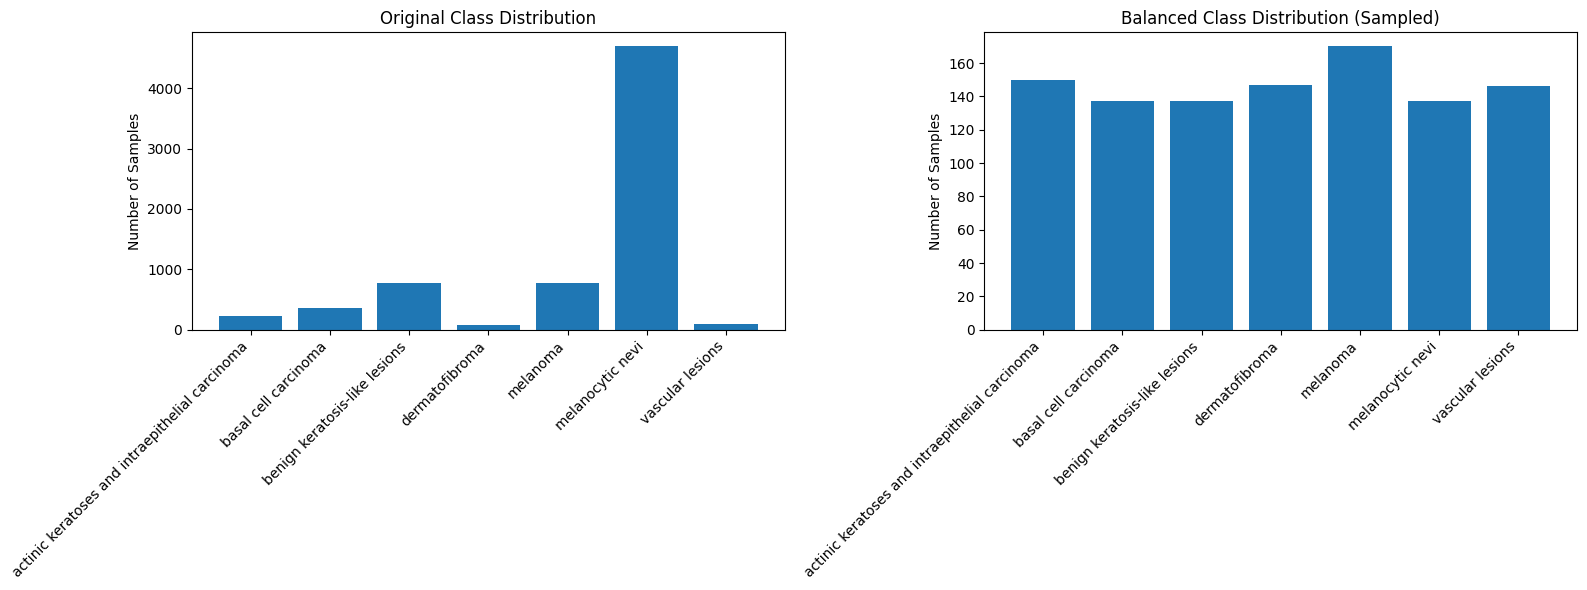

Original Distribution (%):
  actinic keratoses and intraepithelial carcinoma: 3.3%
  basal cell carcinoma: 5.1%
  benign keratosis-like lesions: 11.0%
  dermatofibroma: 1.1%
  melanoma: 11.1%
  melanocytic nevi: 67.0%
  vascular lesions: 1.4%

Balanced Distribution (%):
  actinic keratoses and intraepithelial carcinoma: 14.6%
  basal cell carcinoma: 13.4%
  benign keratosis-like lesions: 13.4%
  dermatofibroma: 14.4%
  melanoma: 16.6%
  melanocytic nevi: 13.4%
  vascular lesions: 14.3%


In [ ]:
# CELL 4
# Visualize balanced dataset distribution

# Extract labels from the balanced loader
balanced_labels = []
for _, labels in balanced_train_loader:
    balanced_labels.extend(labels.cpu().numpy())
    # Stop after collecting a representative sample
    if len(balanced_labels) >= 1000:
        break

# Convert to numpy array and count classes
balanced_labels = np.array(balanced_labels)
balanced_counts = np.bincount(balanced_labels, minlength=len(class_names))

# Create a comparison plot: original vs balanced
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Original distribution
ax1.bar(range(len(class_counts)), class_counts)
ax1.set_xticks(range(len(class_counts)))
class_labels = [get_class_label(i) for i in range(len(class_counts))]
ax1.set_xticklabels(class_labels, rotation=45, ha='right')
ax1.set_title('Original Class Distribution')
ax1.set_ylabel('Number of Samples')

# Balanced distribution
ax2.bar(range(len(balanced_counts)), balanced_counts)
ax2.set_xticks(range(len(balanced_counts)))
ax2.set_xticklabels(class_labels, rotation=45, ha='right')
ax2.set_title('Balanced Class Distribution (Sampled)')
ax2.set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()

# Print class percentages
print("Original Distribution (%):")
original_percentages = class_counts / class_counts.sum() * 100
for i, percent in enumerate(original_percentages):
    class_name = get_class_label(i)
    print(f"  {class_name}: {percent:.1f}%")

print("\nBalanced Distribution (%):")
balanced_percentages = balanced_counts / balanced_counts.sum() * 100
for i, percent in enumerate(balanced_percentages):
    class_name = get_class_label(i)
    print(f"  {class_name}: {percent:.1f}%")

Displaying sample images from each class...


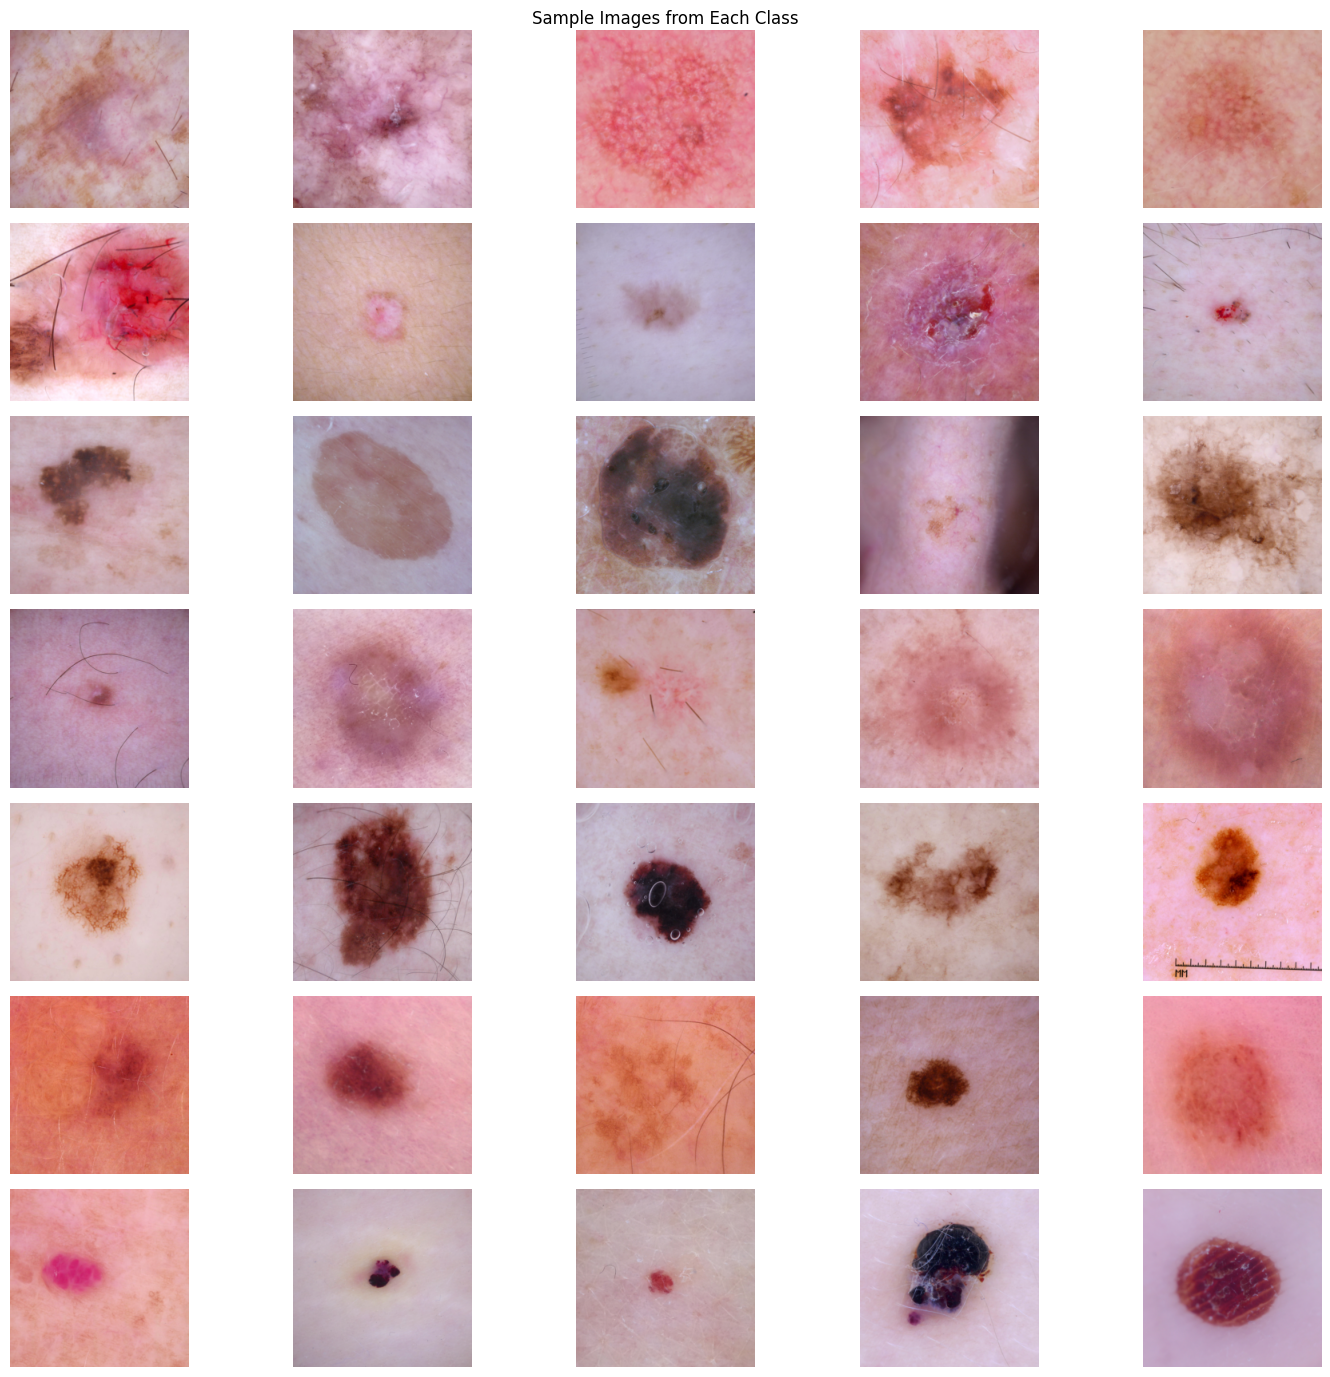

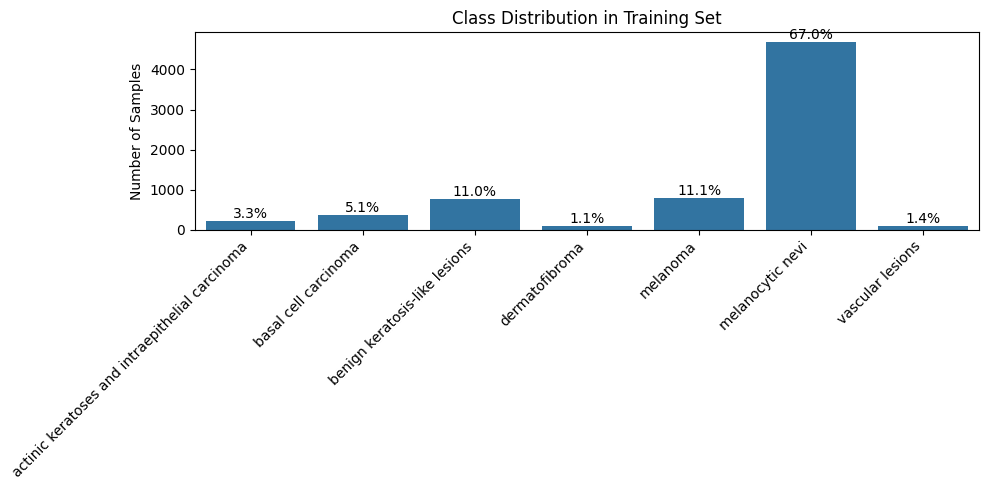

Extracting features for dimensionality reduction...


Extracting features:   0%|          | 0/7007 [00:00<?, ?it/s]

Extracted 1547 features with 0 errors
Computing PCA...


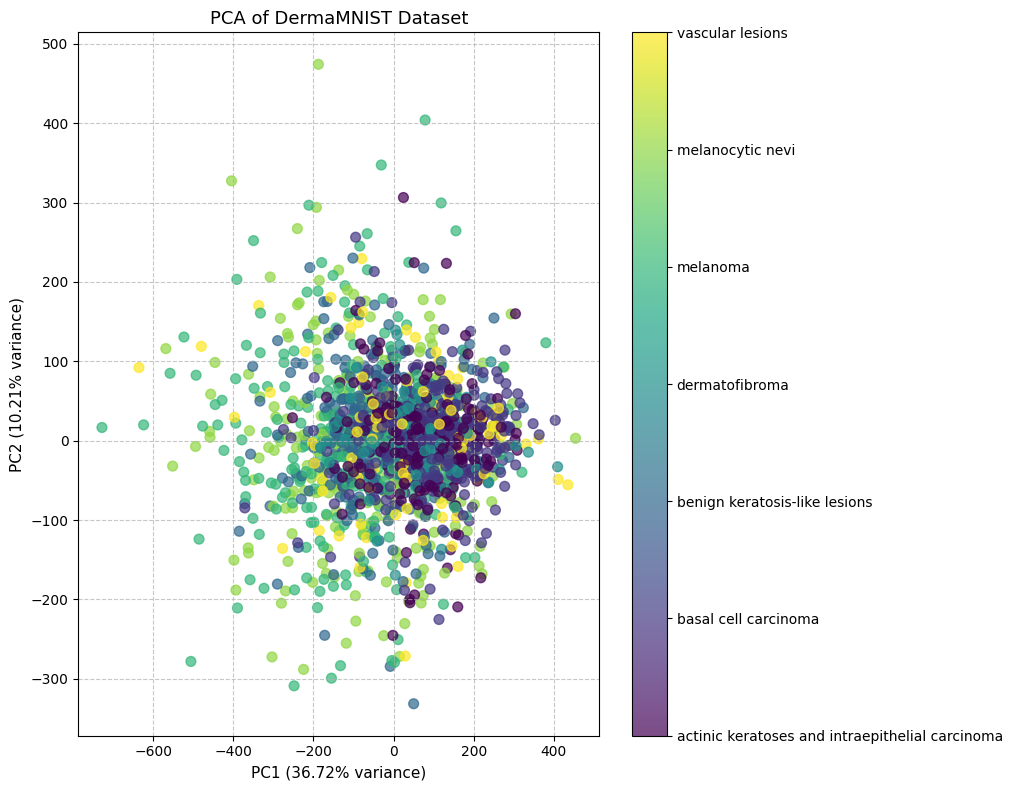

Computing t-SNE (this may take a while)...


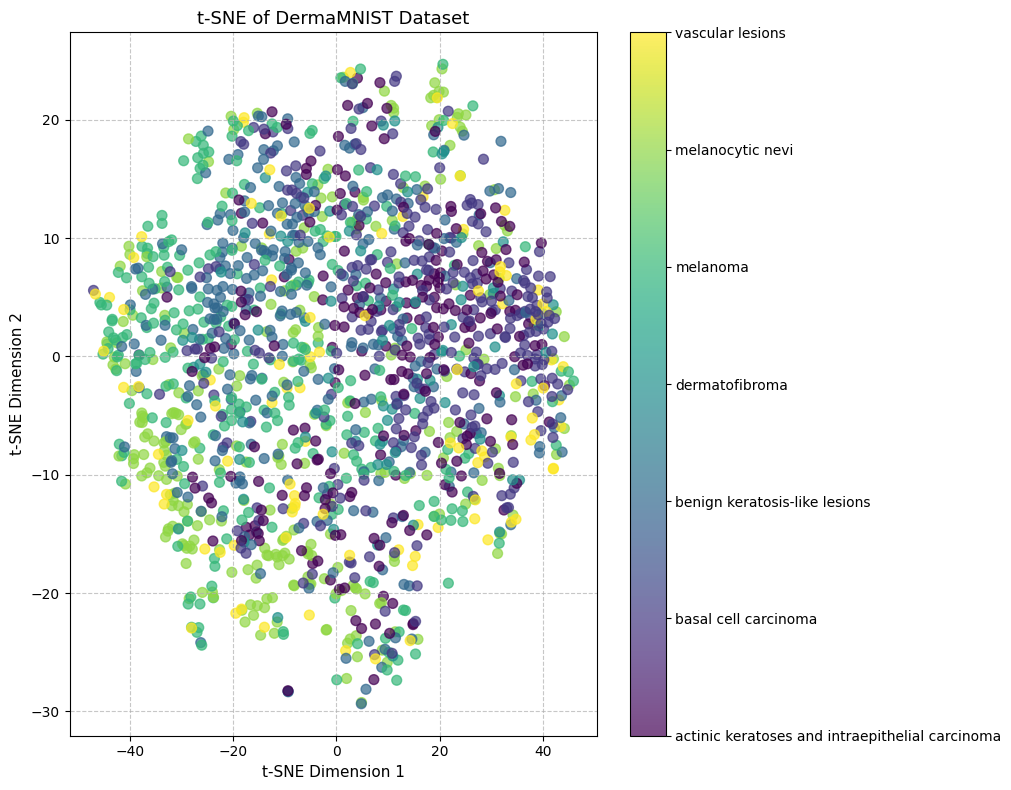

Analyzing image statistics to identify outliers...


Calculating image statistics:   0%|          | 0/1000 [00:00<?, ?it/s]

Processed 1000 images with 0 errors


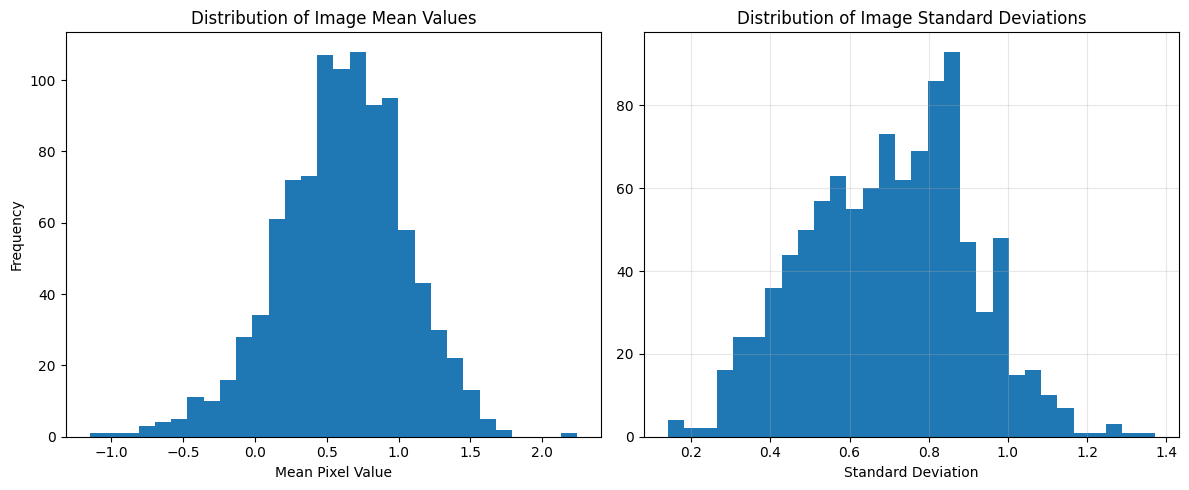

Found 2 potential outlier images
EDA complete.


In [ ]:
# CELL 5
# Exploratory Data Analysis (EDA)

# 1. Visualize sample images from each class
def show_samples(n_samples=5):
    """Plot sample images from each class with robust error handling"""
    try:
        num_classes = len(class_names)
        fig, axes = plt.subplots(num_classes, n_samples, figsize=(15, 2*num_classes))

        # Get indices for each class
        class_indices = {i: [] for i in range(num_classes)}
        for i, (img, label) in enumerate(train_dataset):
            try:
                label_idx = label.item() if hasattr(label, 'item') else int(label)
                if len(class_indices[label_idx]) < n_samples:
                    class_indices[label_idx].append(i)
                if all(len(indices) >= n_samples for indices in class_indices.values()):
                    break
            except (KeyError, TypeError, ValueError) as e:
                print(f"Error processing sample {i}, label {label}: {str(e)}")
                continue

        # Plot samples
        for i, class_idx in enumerate(range(num_classes)):
            for j, idx in enumerate(class_indices[class_idx][:n_samples]):
                try:
                    img, _ = train_dataset[idx]
                    if isinstance(img, torch.Tensor):
                        img = img.numpy().transpose(1, 2, 0)
                    axes[i, j].imshow(img)
                    axes[i, j].axis('off')
                except Exception as e:
                    print(f"Error displaying image {idx}: {str(e)}")
                    axes[i, j].text(0.5, 0.5, 'Error', ha='center', va='center')
                    axes[i, j].axis('off')

            # Use standardized class label function
            axes[i, 0].set_ylabel(get_class_label(class_idx))

        plt.suptitle('Sample Images from Each Class')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Failed to show sample images: {str(e)}")
        traceback_info = traceback.format_exc()
        print(f"Traceback: {traceback_info}")

print("Displaying sample images from each class...")
show_samples()

# 2. Class distribution visualization
try:
    plt.figure(figsize=(10, 5))
    plot_class_names = [get_class_label(i) for i in range(len(class_counts))]

    ax = sns.barplot(x=plot_class_names, y=class_counts)
    plt.title('Class Distribution in Training Set')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45, ha='right')

    # Add percentage annotations
    total = sum(class_counts)
    for i, p in enumerate(ax.patches):
        percentage = 100 * class_counts[i] / total
        ax.annotate(f'{percentage:.1f}%',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'bottom')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Failed to visualize class distribution: {str(e)}")
    traceback_info = traceback.format_exc()
    print(f"Traceback: {traceback_info}")

# 3. Dimensionality reduction for visual exploration
def extract_features(max_samples=2000):
    """Extract features and labels for dimensionality reduction with detailed error logging"""
    features, labels = [], []
    samples_per_class = {i: 0 for i in range(num_classes)}
    max_per_class = max_samples // num_classes
    errors = 0

    for i in tqdm(range(len(train_dataset_transformed)), desc="Extracting features"):
        try:
            img, label = train_dataset_transformed[i]
            label_idx = label.item() if hasattr(label, 'item') else int(label)

            if samples_per_class[label_idx] < max_per_class:
                if isinstance(img, torch.Tensor):
                    img_flat = img.flatten().cpu().numpy()
                else:
                    img_flat = img.flatten()

                # Check for invalid values
                if np.isnan(img_flat).any() or np.isinf(img_flat).any():
                    print(f"Warning: Sample {i} contains NaN or Inf values, skipping")
                    errors += 1
                    continue

                features.append(img_flat)
                labels.append(label_idx)
                samples_per_class[label_idx] += 1

            if sum(samples_per_class.values()) >= max_samples:
                break
        except Exception as e:
            print(f"Error processing sample {i}: {str(e)}")
            errors += 1
            if errors > 100:  # Limit number of errors before aborting
                print("Too many errors, aborting feature extraction")
                break

    if not features:
        print("No features extracted! Returning empty arrays")
        return np.array([]), np.array([])

    print(f"Extracted {len(features)} features with {errors} errors")
    return np.array(features), np.array(labels)

print("Extracting features for dimensionality reduction...")
features, labels = extract_features()

# Check if features were successfully extracted
if len(features) == 0:
    print("No features were extracted, skipping dimensionality reduction")
else:
    # PCA visualization
    try:
        print("Computing PCA...")
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(features)

        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1],
                            c=labels, cmap='viridis', alpha=0.7, s=50)
        plt.title('PCA of DermaMNIST Dataset', fontsize=13)
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=11)
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=11)
        plt.grid(True, linestyle='--', alpha=0.7)

        # Add colorbar with class labels
        cbar = plt.colorbar(scatter, ticks=range(num_classes))
        cbar_labels = [get_class_label(i) for i in range(num_classes)]
        cbar.ax.set_yticklabels(cbar_labels)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Failed to compute or visualize PCA: {str(e)}")
        traceback_info = traceback.format_exc()
        print(f"Traceback: {traceback_info}")

    # t-SNE visualization
    try:
        print("Computing t-SNE (this may take a while)...")
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        tsne_result = tsne.fit_transform(features)

        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1],
                            c=labels, cmap='viridis', alpha=0.7, s=50)
        plt.title('t-SNE of DermaMNIST Dataset', fontsize=13)
        plt.xlabel('t-SNE Dimension 1', fontsize=11)
        plt.ylabel('t-SNE Dimension 2', fontsize=11)
        plt.grid(True, linestyle='--', alpha=0.7)

        # Add colorbar with class labels
        cbar = plt.colorbar(scatter, ticks=range(num_classes))
        cbar_labels = [get_class_label(i) for i in range(num_classes)]
        cbar.ax.set_yticklabels(cbar_labels)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Failed to compute or visualize t-SNE: {str(e)}")
        traceback_info = traceback.format_exc()
        print(f"Traceback: {traceback_info}")

# 4. Image quality analysis
def analyze_image_stats(n_samples=1000):
    """Analyze image statistics with robust error handling"""
    mean_values, std_values = [], []
    errors = 0

    try:
        indices = np.random.choice(len(train_dataset_transformed),
                                   min(n_samples, len(train_dataset_transformed)),
                                   replace=False)

        for idx in tqdm(indices, desc="Calculating image statistics"):
            try:
                img, _ = train_dataset_transformed[idx]

                # Verify image is a tensor and convert to numpy
                if isinstance(img, torch.Tensor):
                    img_np = img.cpu().numpy()
                else:
                    img_np = np.array(img)

                # Check for invalid values
                if np.isnan(img_np).any() or np.isinf(img_np).any():
                    print(f"Warning: Image {idx} contains NaN or Inf values, skipping")
                    errors += 1
                    continue

                mean_values.append(np.mean(img_np))
                std_values.append(np.std(img_np))
            except Exception as e:
                print(f"Error processing image {idx}: {str(e)}")
                errors += 1

                if errors > 50:  # Limit number of errors before aborting
                    print("Too many errors, aborting analysis")
                    break

        print(f"Processed {len(mean_values)} images with {errors} errors")

        # Only plot if we have enough valid data
        if len(mean_values) > 10:
            # Plot statistics
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            ax1.hist(mean_values, bins=30)
            ax1.set_title('Distribution of Image Mean Values')
            ax1.set_xlabel('Mean Pixel Value')
            ax1.set_ylabel('Frequency')

            ax2.hist(std_values, bins=30)
            ax2.set_title('Distribution of Image Standard Deviations')
            ax2.set_xlabel('Standard Deviation')
            ax2.grid(alpha=0.3)

            plt.tight_layout()
            plt.show()

            # Identify potential outliers (images with statistics > 3 standard deviations from mean)
            if len(mean_values) > 1:  # Need at least 2 values to calculate std
                mean_threshold = np.mean(mean_values) + 3 * np.std(mean_values)
                std_threshold = np.mean(std_values) + 3 * np.std(std_values)

                outliers = [(indices[i], mean_values[i], std_values[i])
                           for i in range(len(indices))
                           if i < len(mean_values) and (mean_values[i] > mean_threshold or std_values[i] > std_threshold)]

                return outliers
            else:
                print("Not enough valid data to identify outliers")
                return []
        else:
            print("Not enough valid data to generate plots")
            return []

    except Exception as e:
        print(f"Failed to analyze image statistics: {str(e)}")
        traceback_info = traceback.format_exc()
        print(f"Traceback: {traceback_info}")
        return []

print("Analyzing image statistics to identify outliers...")
outliers = analyze_image_stats()
print(f"Found {len(outliers)} potential outlier images")

print("EDA complete.")

In [ ]:
# CELL 6
# Color Feature Extraction

# Global tracking of failed extractions
failed_extractions = {
    'color': [],
    'texture': [],
    'shape': []
}

# Function to normalize image to appropriate format
def normalize_image(image):
    """
    Convert image to numpy array in RGB format with values in [0,1]
    Handles various input types: PIL.Image, torch.Tensor, numpy array
    """
    # Handle PIL Image
    if isinstance(image, Image.Image):
        image = np.array(image) / 255.0
        # If grayscale, convert to RGB
        if len(image.shape) == 2:
            image = np.stack([image, image, image], axis=2)
    # Handle torch Tensor
    elif isinstance(image, torch.Tensor):
        # Ensure 3 channels
        if image.dim() == 2:  # Single channel
            image = image.unsqueeze(0).repeat(3, 1, 1)
        elif image.shape[0] == 1:  # Single channel in CHW
            image = image.repeat(3, 1, 1)

        image = image.numpy().transpose(1, 2, 0)
        if image.max() > 1.0:
            image = image / 255.0
    # Handle numpy array
    elif isinstance(image, np.ndarray):
        if image.max() > 1.0:
            image = image / 255.0
        # If grayscale, convert to RGB
        if len(image.shape) == 2:
            image = np.stack([image, image, image], axis=2)
        elif len(image.shape) == 3 and image.shape[0] == 3:  # CHW format
            image = image.transpose(1, 2, 0)
        elif len(image.shape) == 3 and image.shape[0] == 1:  # Single channel CHW
            image = np.repeat(image, 3, axis=0).transpose(1, 2, 0)

    # Ensure RGB order, not BGR
    return image

# Wrapper function to handle extraction failures
def safe_extract(extract_function, image, feature_type, image_idx=None):
    """
    Wrapper for feature extraction that properly tracks failures

    Args:
        extract_function: The feature extraction function to call
        image: The image to extract features from
        feature_type: Type of features ('color', 'texture', 'shape')
        image_idx: Optional index of the image in the dataset

    Returns:
        The extracted features or raises an exception
    """
    try:
        return extract_function(image)
    except Exception as e:
        # Record the failure
        error_info = {
            'image_idx': image_idx,
            'error': str(e),
            'image_shape': getattr(image, 'shape', 'unknown')
        }
        failed_extractions[feature_type].append(error_info)

        # Always raise the exception to prevent silent failures
        raise

# Function to extract color histograms with fixed bins
def extract_color_histograms(image, bins=16):
    """Extract color histograms from an image in RGB and HSV color spaces."""
    # Convert to proper format
    image = normalize_image(image)

    # Extract RGB histograms
    hist_r = np.histogram(image[:,:,0], bins=bins, range=(0, 1))[0]
    hist_g = np.histogram(image[:,:,1], bins=bins, range=(0, 1))[0]
    hist_b = np.histogram(image[:,:,2], bins=bins, range=(0, 1))[0]

    # Convert to HSV and extract histograms
    hsv_image = color.rgb2hsv(image)
    hist_h = np.histogram(hsv_image[:,:,0], bins=bins, range=(0, 1))[0]
    hist_s = np.histogram(hsv_image[:,:,1], bins=bins, range=(0, 1))[0]
    hist_v = np.histogram(hsv_image[:,:,2], bins=bins, range=(0, 1))[0]

    # Normalize histograms
    total_pixels = image.shape[0] * image.shape[1]
    hist_features = np.concatenate([
        hist_r / total_pixels,
        hist_g / total_pixels,
        hist_b / total_pixels,
        hist_h / total_pixels,
        hist_s / total_pixels,
        hist_v / total_pixels
    ])

    return hist_features

# Function to extract color moments
def extract_color_moments(image):
    """Extract color moments (mean, std, skewness) from an image."""
    # Convert to proper format
    image = normalize_image(image)

    # Extract moments for RGB
    mean_r, mean_g, mean_b = np.mean(image[:,:,0]), np.mean(image[:,:,1]), np.mean(image[:,:,2])
    std_r, std_g, std_b = np.std(image[:,:,0]), np.std(image[:,:,1]), np.std(image[:,:,2])
    skew_r = skew(image[:,:,0].flatten())
    skew_g = skew(image[:,:,1].flatten())
    skew_b = skew(image[:,:,2].flatten())

    # Convert to HSV and extract moments
    hsv_image = color.rgb2hsv(image)
    mean_h, mean_s, mean_v = np.mean(hsv_image[:,:,0]), np.mean(hsv_image[:,:,1]), np.mean(hsv_image[:,:,2])
    std_h, std_s, std_v = np.std(hsv_image[:,:,0]), np.std(hsv_image[:,:,1]), np.std(hsv_image[:,:,2])
    skew_h = skew(hsv_image[:,:,0].flatten())
    skew_s = skew(hsv_image[:,:,1].flatten())
    skew_v = skew(hsv_image[:,:,2].flatten())

    # Create a fixed-length feature array
    moment_features = np.array([
        mean_r, mean_g, mean_b,
        std_r, std_g, std_b,
        skew_r, skew_g, skew_b,
        mean_h, mean_s, mean_v,
        std_h, std_s, std_v,
        skew_h, skew_s, skew_v
    ])

    return moment_features

# Function to extract color correlogram with fixed length output
def extract_color_correlogram(image, distances=[1], levels=4):
    """Extract simplified color correlogram features."""
    # Convert to proper format
    image = normalize_image(image)

    # Convert to uint8 for GLCM
    image_uint8 = (image * 255).astype(np.uint8)

    # Quantize each channel
    quantized_r = np.floor(image_uint8[:,:,0] / (256 / levels)).astype(np.uint8)
    quantized_g = np.floor(image_uint8[:,:,1] / (256 / levels)).astype(np.uint8)
    quantized_b = np.floor(image_uint8[:,:,2] / (256 / levels)).astype(np.uint8)

    # Only use essential properties
    props = ['contrast', 'homogeneity', 'energy']  # Reduced from 5 to 3 properties

    # Pre-allocate the feature array (3 channels * 3 properties * len(distances))
    feature_length = 3 * len(props) * len(distances)
    correlogram_features = np.zeros(feature_length)

    feature_idx = 0
    for d in distances:
        # Create co-occurrence matrix for each channel
        glcm_r = graycomatrix(quantized_r, distances=[d], angles=[0, np.pi/2],  # Reduced angles
                            levels=levels, symmetric=True, normed=True)
        glcm_g = graycomatrix(quantized_g, distances=[d], angles=[0, np.pi/2],
                            levels=levels, symmetric=True, normed=True)
        glcm_b = graycomatrix(quantized_b, distances=[d], angles=[0, np.pi/2],
                            levels=levels, symmetric=True, normed=True)

        # Extract properties
        for prop in props:
            correlogram_features[feature_idx] = graycoprops(glcm_r, prop)[0].mean()
            feature_idx += 1
            correlogram_features[feature_idx] = graycoprops(glcm_g, prop)[0].mean()
            feature_idx += 1
            correlogram_features[feature_idx] = graycoprops(glcm_b, prop)[0].mean()
            feature_idx += 1

    return correlogram_features

# Function to extract all color features with consistent dimensions
def extract_all_color_features(image):
    """Extract all color features from an image with consistent dimensions."""
    # Define bins and distances (reduced for efficiency)
    bins = 16
    distances = [1]
    props = ['contrast', 'homogeneity', 'energy']

    # Extract features
    hist_features = extract_color_histograms(image, bins=bins)
    moment_features = extract_color_moments(image)
    correlogram_features = extract_color_correlogram(image, distances=distances)

    # Combine all features
    all_features = np.concatenate([hist_features, moment_features, correlogram_features])

    # Check for NaN or inf values
    if np.isnan(all_features).any() or np.isinf(all_features).any():
        bad_values = np.sum(np.isnan(all_features)) + np.sum(np.isinf(all_features))
        raise ValueError(f"Feature extraction produced {bad_values} invalid values (NaN/inf)")

    return all_features

# Define worker function at module level (not nested) for multiprocessing compatibility
def _parallel_extract_worker(args):
    """Worker function for parallel processing that can be pickled"""
    idx, image, feature_func, feature_type = args
    return idx, safe_extract(feature_func, image, feature_type, idx)

# Updated extract_features_in_parallel that works with multiprocessing
def extract_features_in_parallel(images, feature_func, feature_type='color', n_workers=None):
    """Extract features using parallel processing with proper error handling."""
    n_workers = n_workers or min(cpu_count(), 8)

    # Create arguments for the worker function
    worker_args = [(idx, image, feature_func, feature_type) for idx, image in enumerate(images)]

    with Pool(n_workers) as pool:
        # Use try-except to catch any exceptions from worker processes
        try:
            results = []
            for result in tqdm(
                pool.imap(_parallel_extract_worker, worker_args),
                total=len(images),
                desc=f"Extracting {feature_type} features with {n_workers} workers"
            ):
                results.append(result)

            # Check if any extractions failed
            if failed_extractions[feature_type]:
                print(f"\n⚠️ WARNING: {len(failed_extractions[feature_type])} {feature_type} feature extractions failed")
                print(f"Failed indices: {[f['image_idx'] for f in failed_extractions[feature_type][:5]]}" +
                      ("..." if len(failed_extractions[feature_type]) > 5 else ""))

                # Halt execution if failures exceed threshold
                failure_rate = len(failed_extractions[feature_type]) / len(images)
                if failure_rate > 0.1:  # 10% threshold
                    raise RuntimeError(f"Too many extraction failures ({failure_rate:.1%}). Stopping execution.")

            # Sort results by index and extract only the features
            results.sort(key=lambda x: x[0])
            features = [r[1] for r in results]
            return np.array(features)

        except Exception as e:
            print(f"\n❌ ERROR during {feature_type} feature extraction: {str(e)}")
            print(f"Failed samples: {len(failed_extractions[feature_type])}/{len(images)}")
            raise

# Collect images and labels from dataloader
def collect_from_dataloader(dataloader, max_samples=None):
    """Collect all images and labels from a dataloader."""
    all_images = []
    all_labels = []
    sample_count = 0

    for images, labels in tqdm(dataloader, desc="Collecting data"):
        for i in range(len(images)):
            # Convert tensor to numpy
            img = images[i].cpu().numpy() if isinstance(images[i], torch.Tensor) else images[i]
            label = labels[i].item() if hasattr(labels[i], 'item') else labels[i]

            all_images.append(img)
            all_labels.append(label)

            sample_count += 1
            if max_samples is not None and sample_count >= max_samples:
                break

        if max_samples is not None and sample_count >= max_samples:
            break

    return all_images, all_labels

# Extract color features using parallel processing
print("Extracting color features from the balanced training dataset...")
images, labels = collect_from_dataloader(balanced_train_loader, max_samples=None)
print(f"Collected {len(images)} images for feature extraction")

X_train_color = extract_features_in_parallel(images, extract_all_color_features, feature_type='color')
y_train_color = np.array(labels)

# Display shape of extracted features
print(f"Extracted features shape: {X_train_color.shape}")
print(f"Labels shape: {y_train_color.shape}")

# Save features to avoid recomputing
np.save('X_train_color_features.npy', X_train_color)
np.save('y_train_color.npy', y_train_color)

# Count feature types
hist_length = 16 * 6  # 6 channels (RGB+HSV) with 16 bins each
moment_length = 18    # 3 moments * 6 channels
correlogram_length = 9  # 3 channels * 3 properties * 1 distance

print("\nFeature breakdown:")
print(f"Color histograms: {hist_length} features")
print(f"Color moments: {moment_length} features")
print(f"Color correlogram: {correlogram_length} features")
print(f"Total: {hist_length + moment_length + correlogram_length} features")

Extracting color features from the balanced training dataset...


Collected 7007 images for feature extraction


Extracting color features with 8 workers:   0%|          | 0/7007 [00:00<?, ?it/s]

Extracted features shape: (7007, 123)
Labels shape: (7007,)

Feature breakdown:
Color histograms: 96 features
Color moments: 18 features
Color correlogram: 9 features
Total: 123 features


In [ ]:
# CELL 7
# Texture Feature Extraction

# Global tracking of failed extractions if not already defined
if 'failed_extractions' not in globals():
    failed_extractions = {
        'color': [],
        'texture': [],
        'shape': []
    }

# Define safe extraction wrapper if not already defined
if 'safe_extract' not in globals():
    def safe_extract(extract_function, image, feature_type, image_idx=None):
        """Wrapper for feature extraction that properly tracks failures"""
        try:
            return extract_function(image)
        except Exception as e:
            failed_extractions[feature_type].append({
                'image_idx': image_idx,
                'error': str(e),
                'image_shape': getattr(image, 'shape', 'unknown')
            })
            raise

# Function to extract Local Binary Pattern (LBP) features with fixed dtype
def extract_lbp_features(image, P=8, R=1, method='uniform'):
    """Extract LBP texture features from an image."""
    # Convert to proper format
    image = normalize_image(image)

    # Convert to grayscale for LBP
    if image.shape[2] == 3:
        gray = np.dot(image, [0.299, 0.587, 0.114])
    else:
        gray = image[:,:,0]

    # Convert to uint8 to fix the warning
    gray_uint8 = (gray * 255).astype(np.uint8)

    # Calculate LBP
    lbp = local_binary_pattern(gray_uint8, P, R, method)

    # Create histogram of LBP values
    n_bins = P + 2 if method == 'uniform' else 2**P
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    return hist

# Function to extract Histogram of Oriented Gradients (HOG) features
def extract_hog_features(image, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
    """Extract HOG features with larger cell size for efficiency."""
    # Convert to proper format
    image = normalize_image(image)

    # Calculate HOG features
    hog_features = hog(
        image,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        channel_axis=2,  # RGB image
        feature_vector=True
    )

    return hog_features

# Function to extract all texture features
def extract_all_texture_features(image):
    """Extract all texture features from an image."""
    # Extract LBP features
    lbp_features = extract_lbp_features(image)

    # Extract HOG features with larger cell size
    hog_features = extract_hog_features(image)

    # Combine features
    all_features = np.concatenate([lbp_features, hog_features])

    # Check for NaN or inf values
    if np.isnan(all_features).any() or np.isinf(all_features).any():
        bad_values = np.sum(np.isnan(all_features)) + np.sum(np.isinf(all_features))
        raise ValueError(f"Texture feature extraction produced {bad_values} invalid values (NaN/inf)")

    return all_features

# Define worker function at module level (not nested) for multiprocessing compatibility
def _parallel_extract_worker(args):
    """Worker function for parallel processing that can be pickled"""
    idx, image, feature_func, feature_type = args
    return idx, safe_extract(feature_func, image, feature_type, idx)

# Updated extract_features_in_parallel to work with multiprocessing
def extract_features_in_parallel(images, feature_func, feature_type='texture', n_workers=None):
    """Extract features using parallel processing with proper error handling."""
    n_workers = n_workers or min(cpu_count(), 8)

    # Create arguments for the worker function
    worker_args = [(idx, image, feature_func, feature_type) for idx, image in enumerate(images)]

    with Pool(n_workers) as pool:
        try:
            results = []
            for result in tqdm(
                pool.imap(_parallel_extract_worker, worker_args),
                total=len(images),
                desc=f"Extracting {feature_type} features with {n_workers} workers"
            ):
                results.append(result)

            # Check if any extractions failed
            if failed_extractions[feature_type]:
                print(f"\n⚠️ WARNING: {len(failed_extractions[feature_type])} {feature_type} feature extractions failed")
                print(f"Failed indices: {[f['image_idx'] for f in failed_extractions[feature_type][:5]]}" +
                    ("..." if len(failed_extractions[feature_type]) > 5 else ""))

                # Halt execution if failures exceed threshold
                failure_rate = len(failed_extractions[feature_type]) / len(images)
                if failure_rate > 0.1:  # 10% threshold
                    raise RuntimeError(f"Too many extraction failures ({failure_rate:.1%}). Stopping execution.")

            # Sort results by index and extract only the features
            results.sort(key=lambda x: x[0])
            features = [r[1] for r in results]
            return np.array(features)

        except Exception as e:
            print(f"\n❌ ERROR during {feature_type} feature extraction: {str(e)}")
            print(f"Failed samples: {len(failed_extractions[feature_type])}/{len(images)}")
            raise

# Extract texture features using parallel processing
print("Extracting texture features from the balanced training dataset...")
# Reuse images and labels if available
if 'images' in globals() and 'labels' in globals():
    print(f"Using {len(images)} images already loaded")
else:
    images, labels = collect_from_dataloader(balanced_train_loader, max_samples=None)
    print(f"Collected {len(images)} images for feature extraction")

X_train_texture = extract_features_in_parallel(images, extract_all_texture_features, feature_type='texture')
y_train_texture = np.array(labels)

# Display shape of extracted features
print(f"Extracted texture features shape: {X_train_texture.shape}")
print(f"Labels shape: {y_train_texture.shape}")

# Save features to avoid recomputing
np.save('X_train_texture_features.npy', X_train_texture)
np.save('y_train_texture.npy', y_train_texture)

# Display feature breakdown
try:
    first_img = images[0] if len(images) > 0 else None
    if first_img is not None:
        lbp_length = len(extract_lbp_features(first_img))
        hog_length = len(extract_hog_features(first_img))

        print("\nTexture feature breakdown:")
        print(f"LBP features: {lbp_length}")
        print(f"HOG features: {hog_length}")
        print(f"Total: {lbp_length + hog_length} texture features")
except Exception as e:
    print(f"Error calculating feature breakdown: {str(e)}")

Extracting texture features from the balanced training dataset...
Using 7007 images already loaded


Extracting texture features with 8 workers:   0%|          | 0/7007 [00:00<?, ?it/s]

Extracted texture features shape: (7007, 6094)
Labels shape: (7007,)

Texture feature breakdown:
LBP features: 10
HOG features: 6084
Total: 6094 texture features


In [ ]:
# CELL 8
# Shape Feature Extraction

# Global tracking of failed extractions if not already defined
if 'failed_extractions' not in globals():
    failed_extractions = {
        'color': [],
        'texture': [],
        'shape': []
    }

# Define safe extraction wrapper if not already defined
if 'safe_extract' not in globals():
    def safe_extract(extract_function, image, feature_type, image_idx=None):
        """Wrapper for feature extraction that properly tracks failures"""
        try:
            return extract_function(image)
        except Exception as e:
            failed_extractions[feature_type].append({
                'image_idx': image_idx,
                'error': str(e),
                'image_shape': getattr(image, 'shape', 'unknown')
            })
            raise

# Improved contour extraction with fallback methods
def extract_contour_features(image):
    """Extract contour-based shape features with multiple fallback methods."""
    # Convert to proper format
    image = normalize_image(image)

    # Convert to grayscale and uint8
    gray = np.dot(image, [0.299, 0.587, 0.114])
    gray = (gray * 255).astype(np.uint8)

    # Try multiple thresholding methods
    contours = None

    # Method 1: Otsu's thresholding
    _, thresh_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours_otsu, _ = cv2.findContours(thresh_otsu, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours_otsu and len(contours_otsu) > 0:
        contours = contours_otsu
    else:
        # Method 2: Adaptive thresholding
        thresh_adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                               cv2.THRESH_BINARY, 11, 2)
        contours_adaptive, _ = cv2.findContours(thresh_adaptive, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours_adaptive and len(contours_adaptive) > 0:
            contours = contours_adaptive
        else:
            # Method 3: Simple binary thresholding
            _, thresh_simple = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
            contours_simple, _ = cv2.findContours(thresh_simple, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours_simple and len(contours_simple) > 0:
                contours = contours_simple

    # If still no contours found, create a dummy contour for the entire image
    if not contours or len(contours) == 0:
        # Create a rectangular contour around the entire image
        h, w = gray.shape
        dummy_contour = np.array([[[0, 0]], [[w-1, 0]], [[w-1, h-1]], [[0, h-1]]])
        contours = [dummy_contour]

    # Take largest contour
    contour = max(contours, key=cv2.contourArea)

    # Contour area and perimeter
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    # Default value for division by zero cases
    default_value = 0.0

    # Circularity (with safety check)
    if perimeter > 0:
        circularity = 4 * np.pi * area / (perimeter * perimeter)
    else:
        circularity = default_value

    # Convex hull
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)

    # Solidity (with safety check)
    if hull_area > 0:
        solidity = float(area) / hull_area
    else:
        solidity = default_value

    # Bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)

    # Aspect ratio (with safety check)
    if h > 0:
        aspect_ratio = float(w) / h
    else:
        aspect_ratio = default_value

    # Extent (with safety check)
    rect_area = w * h
    if rect_area > 0:
        extent = float(area) / rect_area
    else:
        extent = default_value

    # Equivalent diameter
    equi_diameter = np.sqrt(4 * area / np.pi) if area > 0 else default_value

    # Feature array
    features = np.array([
        area / (image.shape[0] * image.shape[1]),  # Normalized area
        perimeter / (2 * (image.shape[0] + image.shape[1])),  # Normalized perimeter
        circularity,
        solidity,
        aspect_ratio,
        extent,
        equi_diameter / max(image.shape[0], image.shape[1]),  # Normalized diameter
        len(contours)  # Number of contours
    ])

    return features

# Function to extract moment-based features
def extract_moment_features(image):
    """Extract moment-based shape features with error handling."""
    # Convert to proper format
    image = normalize_image(image)

    # Convert to grayscale and uint8
    gray = np.dot(image, [0.299, 0.587, 0.114])
    gray = (gray * 255).astype(np.uint8)

    # Calculate moments
    moments = cv2.moments(gray)

    # Check if moments are valid
    if moments['m00'] == 0:
        # Create fallback moments
        # Use the center of mass as the center of the image
        h, w = gray.shape
        cx, cy = w/2, h/2
        # Create a minimal set of valid moments
        for i in range(4):
            for j in range(4):
                if i + j <= 3:  # We need moments up to 3rd order
                    moments[f'm{i}{j}'] = cx**i * cy**j
        moments['m00'] = 1.0  # Avoid division by zero

    # Hu moments (7 invariant moments)
    hu_moments = cv2.HuMoments(moments).flatten()

    # Log transform Hu moments (to handle large range differences)
    for i in range(len(hu_moments)):
        if hu_moments[i] != 0:
            hu_moments[i] = -np.sign(hu_moments[i]) * np.log10(abs(hu_moments[i]))
        else:
            hu_moments[i] = 0.0  # Set to 0 if the moment is 0 to avoid log(0)

    return hu_moments

# Function to combine all shape features
def extract_all_shape_features(image):
    """Extract all shape features from an image."""
    # Extract contour features
    contour_features = extract_contour_features(image)

    # Extract moment features
    moment_features = extract_moment_features(image)

    # Combine all features
    all_features = np.concatenate([contour_features, moment_features])

    # Check for NaN or inf values
    if np.isnan(all_features).any() or np.isinf(all_features).any():
        # Replace NaN/inf with zeros instead of raising an error
        all_features = np.nan_to_num(all_features)

    return all_features

# Define worker function at module level for multiprocessing compatibility
def _parallel_extract_worker(args):
    """Worker function for parallel processing that can be pickled"""
    idx, image, feature_func, feature_type = args
    return idx, safe_extract(feature_func, image, feature_type, idx)

# Updated extract_features_in_parallel to work with multiprocessing
def extract_features_in_parallel(images, feature_func, feature_type='shape', n_workers=None):
    """Extract features using parallel processing with proper error handling."""
    n_workers = n_workers or min(cpu_count(), 8)

    # Create arguments for the worker function
    worker_args = [(idx, image, feature_func, feature_type) for idx, image in enumerate(images)]

    with Pool(n_workers) as pool:
        try:
            results = []
            for result in tqdm(
                pool.imap(_parallel_extract_worker, worker_args),
                total=len(images),
                desc=f"Extracting {feature_type} features with {n_workers} workers"
            ):
                results.append(result)

            # Check if any extractions failed
            if failed_extractions[feature_type]:
                print(f"\n⚠️ WARNING: {len(failed_extractions[feature_type])} {feature_type} feature extractions failed")
                print(f"Failed indices: {[f['image_idx'] for f in failed_extractions[feature_type][:5]]}" +
                    ("..." if len(failed_extractions[feature_type]) > 5 else ""))

                # Halt execution if failures exceed threshold
                failure_rate = len(failed_extractions[feature_type]) / len(images)
                if failure_rate > 0.1:  # 10% threshold
                    raise RuntimeError(f"Too many extraction failures ({failure_rate:.1%}). Stopping execution.")

            # Sort results by index and extract only the features
            results.sort(key=lambda x: x[0])
            features = [r[1] for r in results]
            return np.array(features)

        except Exception as e:
            print(f"\n❌ ERROR during {feature_type} feature extraction: {str(e)}")
            print(f"Failed samples: {len(failed_extractions[feature_type])}/{len(images)}")
            raise

# Extract shape features using parallel processing
print("Extracting shape features from the balanced training dataset...")
# Reuse images and labels if available
if 'images' in globals() and 'labels' in globals():
    print(f"Using {len(images)} images already loaded")
else:
    images, labels = collect_from_dataloader(balanced_train_loader, max_samples=None)
    print(f"Collected {len(images)} images for feature extraction")

X_train_shape = extract_features_in_parallel(images, extract_all_shape_features, feature_type='shape')
y_train_shape = np.array(labels)

# Display shape of extracted features
print(f"Extracted shape features shape: {X_train_shape.shape}")
print(f"Labels shape: {y_train_shape.shape}")

# Save features to avoid recomputing
np.save('X_train_shape_features.npy', X_train_shape)
np.save('y_train_shape.npy', y_train_shape)

# Display feature breakdown
contour_length = 8
moment_length = 7

print("\nShape feature breakdown:")
print(f"Contour features: {contour_length}")
print(f"Moment features: {moment_length}")
print(f"Total: {contour_length + moment_length} shape features")

Extracting shape features from the balanced training dataset...
Using 7007 images already loaded


Extracting shape features with 8 workers:   0%|          | 0/7007 [00:00<?, ?it/s]

Extracted shape features shape: (7007, 15)
Labels shape: (7007,)

Shape feature breakdown:
Contour features: 8
Moment features: 7
Total: 15 shape features


In [ ]:
# CELL 9
# Feature Preprocessing with Data Leakage Prevention

# Load extracted features
print("Loading extracted features...")
X_train_color = np.load('X_train_color_features.npy')
y_train_color = np.load('y_train_color.npy')

X_train_texture = np.load('X_train_texture_features.npy')
y_train_texture = np.load('y_train_texture.npy')

X_train_shape = np.load('X_train_shape_features.npy')
y_train_shape = np.load('y_train_shape.npy')

# Verify all feature sets have the same number of samples
print(f"Color features: {X_train_color.shape}")
print(f"Texture features: {X_train_texture.shape}")
print(f"Shape features: {X_train_shape.shape}")

# Ensure we're using the same samples in all feature sets
min_samples = min(X_train_color.shape[0], X_train_texture.shape[0], X_train_shape.shape[0])
X_train_color = X_train_color[:min_samples]
X_train_texture = X_train_texture[:min_samples]
X_train_shape = X_train_shape[:min_samples]
y_train = y_train_color[:min_samples]

print(f"Using {min_samples} samples for all feature sets")

# Concatenate all features
X_train_combined = np.hstack((X_train_color, X_train_texture, X_train_shape))
print(f"Combined training feature matrix shape: {X_train_combined.shape}")

# Create processing pipeline to prevent data leakage
print("\nCreating preprocessing pipeline...")
preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('variance_filter', VarianceThreshold(threshold=0.01)),
    ('selector', SelectKBest(f_classif, k=100))
])

# Fit pipeline on training data only
print("Fitting preprocessing pipeline on training data...")
X_train_processed = preprocessing_pipeline.fit_transform(X_train_combined, y_train)
print(f"Processed training data shape: {X_train_processed.shape}")

# Save the preprocessing pipeline for later use on validation/test data
joblib.dump(preprocessing_pipeline, 'preprocessing_pipeline.joblib')
print("Saved preprocessing pipeline for consistent application to val/test data")

# Save processed datasets
np.save('X_train_processed.npy', X_train_processed)
np.save('y_train.npy', y_train)

# Function to process validation or test data consistently
def process_test_val_data(X_color, X_texture, X_shape, pipeline, pca_model=None):
    """Process test/validation data using pre-fitted pipeline to prevent data leakage"""
    # Concatenate features
    X_combined = np.hstack((X_color, X_texture, X_shape))

    # Apply fitted preprocessing pipeline
    X_processed = pipeline.transform(X_combined)

    # Optionally apply PCA
    if pca_model is not None:
        X_pca = pca_model.transform(X_processed)
        return X_processed, X_pca

    return X_processed

print("\nTo process validation/test data, use:")
print("X_val_processed, X_val_pca = process_test_val_data(X_val_color, X_val_texture, X_val_shape, preprocessing_pipeline, pca)")
print("\nFeature preprocessing complete.")

Loading extracted features...
Color features: (7007, 123)
Texture features: (7007, 6094)
Shape features: (7007, 15)
Using 7007 samples for all feature sets
Combined training feature matrix shape: (7007, 6232)

Creating preprocessing pipeline...
Fitting preprocessing pipeline on training data...
Processed training data shape: (7007, 100)
Saved preprocessing pipeline for consistent application to val/test data

To process validation/test data, use:
X_val_processed, X_val_pca = process_test_val_data(X_val_color, X_val_texture, X_val_shape, preprocessing_pipeline, pca)

Feature preprocessing complete.


In [ ]:
# CELL 10
# Logistic Regression Model with RandomizedSearchCV for faster parameter tuning

# Calculate optimal number of parallel jobs
n_jobs = max(1, multiprocessing.cpu_count() - 1)
print(f"Using {n_jobs} parallel jobs for training")

# Load preprocessed data
print("Loading preprocessed data...")
X_selected = np.load('X_train_processed.npy')  # Use processed features
y = np.load('y_train.npy')  # Class labels

X = X_selected
print(f"Training data shape: {X.shape}")
print(f"Target classes distribution: {np.bincount(y.astype(int))}")

# Initialize 5-fold cross-validation
n_folds = 5
cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

# RandomizedSearchCV for faster parameter search
print("\nPerforming randomized search for Logistic Regression...")
param_distributions = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced']
}

lr_random = RandomizedSearchCV(
    LogisticRegression(max_iter=10000, random_state=42),
    param_distributions=param_distributions,
    n_iter=10,  # Sample only 10 combinations instead of full grid
    cv=cv,
    scoring='f1_macro',
    n_jobs=n_jobs,  # Use optimized parallel processing
    verbose=1,
    random_state=42
)

start_time = time.time()
lr_random.fit(X, y)
end_time = time.time()

print(f"\nBest parameters: {lr_random.best_params_}")
print(f"Best cross-validation score: {lr_random.best_score_:.4f}")
print(f"Time taken: {end_time - start_time:.2f} seconds")

# Train model with best parameters
best_lr = lr_random.best_estimator_

# Perform cross-validation with multiple scoring metrics
print("\nPerforming cross-validation with best parameters...")
cv_results = cross_validate(best_lr, X, y, cv=cv, scoring=scoring, return_train_score=True, n_jobs=n_jobs)

# Display cross-validation results
print("\nCross-Validation Results for Logistic Regression:")
print(f"Mean Training Accuracy: {cv_results['train_accuracy'].mean():.4f} ± {cv_results['train_accuracy'].std():.4f}")
print(f"Mean Validation Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"Mean Validation Precision: {cv_results['test_precision_macro'].mean():.4f} ± {cv_results['test_precision_macro'].std():.4f}")
print(f"Mean Validation Recall: {cv_results['test_recall_macro'].mean():.4f} ± {cv_results['test_recall_macro'].std():.4f}")
print(f"Mean Validation F1 Score: {cv_results['test_f1_macro'].mean():.4f} ± {cv_results['test_f1_macro'].std():.4f}")

# Calculate overfitting ratio
overfit_ratio = cv_results['train_accuracy'].mean() / cv_results['test_accuracy'].mean()
print(f"Overfitting ratio (train/test): {overfit_ratio:.4f}")

# Train the final model on the entire training set
print("\nTraining final model on entire training set...")
best_lr.fit(X, y)

# Save the model
joblib.dump(best_lr, 'logistic_regression_model.joblib')
print("Logistic Regression model saved.")

Using 11 parallel jobs for training
Loading preprocessed data...
Training data shape: (7007, 100)
Target classes distribution: [ 977 1023 1017 1017  972  994 1007]

Performing randomized search for Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters: {'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balanced', 'C': 10}
Best cross-validation score: 0.5415
Time taken: 684.01 seconds

Performing cross-validation with best parameters...

Cross-Validation Results for Logistic Regression:
Mean Training Accuracy: 0.5798 ± 0.0017
Mean Validation Accuracy: 0.5436 ± 0.0048
Mean Validation Precision: 0.5426 ± 0.0050
Mean Validation Recall: 0.5440 ± 0.0054
Mean Validation F1 Score: 0.5415 ± 0.0051
Overfitting ratio (train/test): 1.0667

Training final model on entire training set...
Logistic Regression model saved.


In [ ]:
# CELL 11 (Optimized with regularization)
# Random Forest Model with RandomizedSearchCV

# Calculate optimal number of parallel jobs
n_jobs = max(1, multiprocessing.cpu_count() - 1)
print(f"Using {n_jobs} parallel jobs for training")

# Load preprocessed data
print("Loading preprocessed data...")
X_selected = np.load('X_train_processed.npy')
y = np.load('y_train.npy')

X = X_selected
print(f"Training data shape: {X.shape}")
print(f"Target classes distribution: {np.bincount(y.astype(int))}")

# Initialize 5-fold cross-validation
n_folds = 5
cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

# RandomizedSearchCV with regularization parameters to reduce overfitting
print("\nPerforming randomized search for Random Forest with regularization...")
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 8, 10, 15],  # Lower max_depth values to reduce overfitting
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [3, 5, 8, 10],  # Increased min_samples_leaf to reduce overfitting
    'max_features': ['sqrt', 'log2', 0.3, 0.5],  # Add feature subsampling to reduce overfitting
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=15,
    cv=cv,
    scoring='f1_macro',
    n_jobs=n_jobs,
    verbose=1,
    random_state=42
)

start_time = time.time()
rf_random.fit(X, y)
end_time = time.time()

print(f"\nBest parameters: {rf_random.best_params_}")
print(f"Best cross-validation score: {rf_random.best_score_:.4f}")
print(f"Time taken: {end_time - start_time:.2f} seconds")

# Train model with best parameters
best_rf = rf_random.best_estimator_

# Perform cross-validation with multiple scoring metrics
print("\nPerforming cross-validation with best parameters...")
cv_results = cross_validate(best_rf, X, y, cv=cv, scoring=scoring, return_train_score=True, n_jobs=n_jobs)

# Display cross-validation results
print("\nCross-Validation Results for Random Forest:")
print(f"Mean Training Accuracy: {cv_results['train_accuracy'].mean():.4f} ± {cv_results['train_accuracy'].std():.4f}")
print(f"Mean Validation Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"Mean Validation Precision: {cv_results['test_precision_macro'].mean():.4f} ± {cv_results['test_precision_macro'].std():.4f}")
print(f"Mean Validation Recall: {cv_results['test_recall_macro'].mean():.4f} ± {cv_results['test_recall_macro'].std():.4f}")
print(f"Mean Validation F1 Score: {cv_results['test_f1_macro'].mean():.4f} ± {cv_results['test_f1_macro'].std():.4f}")

# Calculate overfitting ratio
overfit_ratio = cv_results['train_accuracy'].mean() / cv_results['test_accuracy'].mean()
print(f"Overfitting ratio (train/test): {overfit_ratio:.4f}")

# Train the final model on the entire training set
print("\nTraining final model on entire training set...")
best_rf.fit(X, y)

# Save the model
joblib.dump(best_rf, 'random_forest_model.joblib')
print("Random Forest model saved.")

Using 11 parallel jobs for training
Loading preprocessed data...
Training data shape: (7007, 100)
Target classes distribution: [ 977 1023 1017 1017  972  994 1007]

Performing randomized search for Random Forest with regularization...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 0.5, 'max_depth': 15, 'class_weight': 'balanced'}
Best cross-validation score: 0.6698
Time taken: 290.58 seconds

Performing cross-validation with best parameters...

Cross-Validation Results for Random Forest:
Mean Training Accuracy: 0.9506 ± 0.0019
Mean Validation Accuracy: 0.6755 ± 0.0131
Mean Validation Precision: 0.6774 ± 0.0172
Mean Validation Recall: 0.6754 ± 0.0143
Mean Validation F1 Score: 0.6698 ± 0.0137
Overfitting ratio (train/test): 1.4073

Training final model on entire training set...
Random Forest model saved.


In [ ]:
# CELL 12
# XGBoost Model with Enhanced Regularization

# Load preprocessed data
print("Loading preprocessed data...")
X_selected = np.load('X_train_processed.npy')
y = np.load('y_train.npy')

X = X_selected
print(f"Training data shape: {X.shape}")
print(f"Target classes distribution: {np.bincount(y.astype(int))}")

# Initialize cross-validation
n_folds = 5
cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

# Regularization parameters
print("\nPerforming randomized search for XGBoost with enhanced regularization...")
# Balanced regularization approach - not too aggressive
param_distributions = {
    'n_estimators': [200, 300, 400],
    'max_depth': [4, 5, 6],           # Slightly higher max depth
    'learning_rate': [0.03, 0.05, 0.08],  # Moderate learning rates
    'subsample': [0.7, 0.8, 0.9],     # Less aggressive subsampling
    'colsample_bytree': [0.6, 0.7, 0.8],  # Moderate column sampling
    'min_child_weight': [3, 5, 7],    # Moderate min_child_weight
    'gamma': [0.05, 0.1, 0.2],        # Moderate minimum loss reduction
    'reg_alpha': [0.1, 0.5, 1.0],     # Moderate L1 regularization
    'reg_lambda': [1.0, 2.0, 4.0]     # Moderate L2 regularization
}

n_jobs = max(1, multiprocessing.cpu_count() - 1)
xgb_random = RandomizedSearchCV(
    XGBClassifier(random_state=42, eval_metric='mlogloss'),
    param_distributions=param_distributions,
    n_iter=25,  # More iterations
    cv=cv,
    scoring='f1_macro',
    n_jobs=n_jobs,
    verbose=1,
    random_state=42
)

start_time = time.time()
xgb_random.fit(X, y)
end_time = time.time()

print(f"\nBest parameters: {xgb_random.best_params_}")
print(f"Best cross-validation score: {xgb_random.best_score_:.4f}")
print(f"Time taken: {end_time - start_time:.2f} seconds")

# Train model with best parameters
best_xgb = xgb_random.best_estimator_

# Perform cross-validation
print("\nPerforming cross-validation with best parameters...")
cv_results = cross_validate(best_xgb, X, y, cv=cv, scoring=scoring, return_train_score=True)

# Display cross-validation results
print("\nCross-Validation Results for XGBoost:")
print(f"Mean Training Accuracy: {cv_results['train_accuracy'].mean():.4f} ± {cv_results['train_accuracy'].std():.4f}")
print(f"Mean Validation Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"Mean Validation Precision: {cv_results['test_precision_macro'].mean():.4f} ± {cv_results['test_precision_macro'].std():.4f}")
print(f"Mean Validation Recall: {cv_results['test_recall_macro'].mean():.4f} ± {cv_results['test_recall_macro'].std():.4f}")
print(f"Mean Validation F1 Score: {cv_results['test_f1_macro'].mean():.4f} ± {cv_results['test_f1_macro'].std():.4f}")

# Calculate overfitting ratio
overfit_ratio = cv_results['train_accuracy'].mean() / cv_results['test_accuracy'].mean()
print(f"Overfitting ratio (train/test): {overfit_ratio:.4f}")

# Save the model
joblib.dump(best_xgb, 'xgboost_model.joblib')
print("XGBoost model saved.")

Loading preprocessed data...
Training data shape: (7007, 100)
Target classes distribution: [ 977 1023 1017 1017  972  994 1007]

Performing randomized search for XGBoost with enhanced regularization...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best parameters: {'subsample': 0.9, 'reg_lambda': 4.0, 'reg_alpha': 1.0, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.08, 'gamma': 0.05, 'colsample_bytree': 0.7}
Best cross-validation score: 0.7037
Time taken: 435.53 seconds

Performing cross-validation with best parameters...

Cross-Validation Results for XGBoost:
Mean Training Accuracy: 1.0000 ± 0.0000
Mean Validation Accuracy: 0.7067 ± 0.0080
Mean Validation Precision: 0.7051 ± 0.0091
Mean Validation Recall: 0.7065 ± 0.0106
Mean Validation F1 Score: 0.7037 ± 0.0092
Overfitting ratio (train/test): 1.4150
XGBoost model saved.


In [ ]:
# CELL 13
# Support Vector Machine Model with RandomizedSearchCV

# Calculate optimal number of parallel jobs
n_jobs = max(1, multiprocessing.cpu_count() - 1)
print(f"Using {n_jobs} parallel jobs for training")

# Load preprocessed data
print("Loading preprocessed data...")
X_selected = np.load('X_train_processed.npy')
y = np.load('y_train.npy')

X = X_selected
print(f"Training data shape: {X.shape}")
print(f"Target classes distribution: {np.bincount(y.astype(int))}")

# Initialize 5-fold cross-validation
n_folds = 5
cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

# RandomizedSearchCV for SVM with balanced parameter selection
print("\nPerforming randomized search for Support Vector Machine...")
param_distributions = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear', 'poly'],
    'degree': [2, 3],  # Only relevant for poly kernel
    'class_weight': [None, 'balanced']
}

svm_random = RandomizedSearchCV(
    SVC(probability=True, random_state=42),
    param_distributions=param_distributions,
    n_iter=15,
    cv=cv,
    scoring='f1_macro',
    n_jobs=n_jobs,
    verbose=1,
    random_state=42
)

start_time = time.time()
svm_random.fit(X, y)
end_time = time.time()

print(f"\nBest parameters: {svm_random.best_params_}")
print(f"Best cross-validation score: {svm_random.best_score_:.4f}")
print(f"Time taken: {end_time - start_time:.2f} seconds")

# Train model with best parameters
best_svm = svm_random.best_estimator_

# Perform cross-validation with multiple scoring metrics
print("\nPerforming cross-validation with best parameters...")
cv_results = cross_validate(best_svm, X, y, cv=cv, scoring=scoring, return_train_score=True, n_jobs=n_jobs)

# Display cross-validation results
print("\nCross-Validation Results for Support Vector Machine:")
print(f"Mean Training Accuracy: {cv_results['train_accuracy'].mean():.4f} ± {cv_results['train_accuracy'].std():.4f}")
print(f"Mean Validation Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"Mean Validation Precision: {cv_results['test_precision_macro'].mean():.4f} ± {cv_results['test_precision_macro'].std():.4f}")
print(f"Mean Validation Recall: {cv_results['test_recall_macro'].mean():.4f} ± {cv_results['test_recall_macro'].std():.4f}")
print(f"Mean Validation F1 Score: {cv_results['test_f1_macro'].mean():.4f} ± {cv_results['test_f1_macro'].std():.4f}")

# Calculate overfitting ratio
overfit_ratio = cv_results['train_accuracy'].mean() / cv_results['test_accuracy'].mean()
print(f"Overfitting ratio (train/test): {overfit_ratio:.4f}")

# Train the final model on the entire training set
print("\nTraining final model on entire training set...")
best_svm.fit(X, y)

# Save the model
joblib.dump(best_svm, 'svm_model.joblib')
print("Support Vector Machine model saved.")

Using 11 parallel jobs for training
Loading preprocessed data...
Training data shape: (7007, 100)
Target classes distribution: [ 977 1023 1017 1017  972  994 1007]

Performing randomized search for Support Vector Machine...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best parameters: {'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'class_weight': 'balanced', 'C': 10}
Best cross-validation score: 0.5953
Time taken: 731.79 seconds

Performing cross-validation with best parameters...

Cross-Validation Results for Support Vector Machine:
Mean Training Accuracy: 0.9945 ± 0.0005
Mean Validation Accuracy: 0.5954 ± 0.0137
Mean Validation Precision: 0.5984 ± 0.0133
Mean Validation Recall: 0.5953 ± 0.0158
Mean Validation F1 Score: 0.5953 ± 0.0141
Overfitting ratio (train/test): 1.6703

Training final model on entire training set...
Support Vector Machine model saved.


In [ ]:
# CELL 14
# Extra Trees Model with RandomizedSearchCV

# Calculate optimal number of parallel jobs
n_jobs = max(1, multiprocessing.cpu_count() - 1)
print(f"Using {n_jobs} parallel jobs for training")

# Load preprocessed data
print("Loading preprocessed data...")
X_selected = np.load('X_train_processed.npy')
y = np.load('y_train.npy')

X = X_selected
print(f"Training data shape: {X.shape}")
print(f"Target classes distribution: {np.bincount(y.astype(int))}")

# Initialize 5-fold cross-validation
n_folds = 5
cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

# RandomizedSearchCV for Extra Trees with regularization parameters
print("\nPerforming randomized search for Extra Trees...")
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 8, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

et_random = RandomizedSearchCV(
    ExtraTreesClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=15,
    cv=cv,
    scoring='f1_macro',
    n_jobs=n_jobs,
    verbose=1,
    random_state=42
)

start_time = time.time()
et_random.fit(X, y)
end_time = time.time()

print(f"\nBest parameters: {et_random.best_params_}")
print(f"Best cross-validation score: {et_random.best_score_:.4f}")
print(f"Time taken: {end_time - start_time:.2f} seconds")

# Train model with best parameters
best_et = et_random.best_estimator_

# Perform cross-validation with multiple scoring metrics
print("\nPerforming cross-validation with best parameters...")
cv_results = cross_validate(best_et, X, y, cv=cv, scoring=scoring, return_train_score=True, n_jobs=n_jobs)

# Display cross-validation results
print("\nCross-Validation Results for Extra Trees:")
print(f"Mean Training Accuracy: {cv_results['train_accuracy'].mean():.4f} ± {cv_results['train_accuracy'].std():.4f}")
print(f"Mean Validation Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"Mean Validation Precision: {cv_results['test_precision_macro'].mean():.4f} ± {cv_results['test_precision_macro'].std():.4f}")
print(f"Mean Validation Recall: {cv_results['test_recall_macro'].mean():.4f} ± {cv_results['test_recall_macro'].std():.4f}")
print(f"Mean Validation F1 Score: {cv_results['test_f1_macro'].mean():.4f} ± {cv_results['test_f1_macro'].std():.4f}")

# Calculate overfitting ratio
overfit_ratio = cv_results['train_accuracy'].mean() / cv_results['test_accuracy'].mean()
print(f"Overfitting ratio (train/test): {overfit_ratio:.4f}")


# Train the final model on the entire training set
print("\nTraining final model on entire training set...")
best_et.fit(X, y)

# Save the model
joblib.dump(best_et, 'extra_trees_model.joblib')
print("Extra Trees model saved.")

Using 11 parallel jobs for training
Loading preprocessed data...
Training data shape: (7007, 100)
Target classes distribution: [ 977 1023 1017 1017  972  994 1007]

Performing randomized search for Extra Trees...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 15, 'class_weight': 'balanced_subsample', 'bootstrap': False}
Best cross-validation score: 0.6866
Time taken: 25.79 seconds

Performing cross-validation with best parameters...

Cross-Validation Results for Extra Trees:
Mean Training Accuracy: 0.9713 ± 0.0012
Mean Validation Accuracy: 0.6920 ± 0.0075
Mean Validation Precision: 0.6933 ± 0.0094
Mean Validation Recall: 0.6919 ± 0.0090
Mean Validation F1 Score: 0.6866 ± 0.0080
Overfitting ratio (train/test): 1.4036

Training final model on entire training set...
Extra Trees model saved.


In [ ]:
# CELL 15
# Extract and Save Test Features

print("Starting test feature extraction...")
start_time = time.time()

# 1. Collect test images and labels
print("Collecting test images and labels...")
test_images, test_labels = collect_from_dataloader(test_loader)
print(f"Collected {len(test_images)} test images")

# 2. Extract features using existing functions
print("\nExtracting color features...")
X_test_color = extract_features_in_parallel(test_images, extract_all_color_features)
print(f"Color features shape: {X_test_color.shape}")

print("\nExtracting texture features...")
X_test_texture = extract_features_in_parallel(test_images, extract_all_texture_features)
print(f"Texture features shape: {X_test_texture.shape}")

print("\nExtracting shape features...")
X_test_shape = extract_features_in_parallel(test_images, extract_all_shape_features)
print(f"Shape features shape: {X_test_shape.shape}")

# 3. Convert labels to numpy array
y_test = np.array(test_labels)
print(f"Test labels shape: {y_test.shape}")

# 4. Save extracted features
print("\nSaving test features...")
np.save('X_test_color_features.npy', X_test_color)
np.save('X_test_texture_features.npy', X_test_texture)
np.save('X_test_shape_features.npy', X_test_shape)
np.save('y_test.npy', y_test)

# 5. Process features with preprocessing pipeline
print("\nProcessing test features...")
preprocessing_pipeline = joblib.load('preprocessing_pipeline.joblib')
X_test_processed = process_test_val_data(X_test_color, X_test_texture, X_test_shape, preprocessing_pipeline)
print(f"Processed test data shape: {X_test_processed.shape}")

# 6. Save processed features
np.save('X_test_processed.npy', X_test_processed)

end_time = time.time()
print(f"Test feature extraction completed in {end_time - start_time:.2f} seconds")

Starting test feature extraction...


Collected 2005 test images

Extracting color features...


Extracting shape features with 8 workers:   0%|          | 0/2005 [00:00<?, ?it/s]

Color features shape: (2005, 123)

Extracting texture features...


Extracting shape features with 8 workers:   0%|          | 0/2005 [00:00<?, ?it/s]

Texture features shape: (2005, 6094)

Extracting shape features...


Extracting shape features with 8 workers:   0%|          | 0/2005 [00:00<?, ?it/s]

Shape features shape: (2005, 15)
Test labels shape: (2005,)

Saving test features...

Processing test features...
Processed test data shape: (2005, 100)
Test feature extraction completed in 19.02 seconds


Loading models...
Loading data...
Starting three-way evaluation...

--- Calculating Training Metrics ---

Training Performance:
                 Model  Accuracy  Precision  Recall  F1 Score
0  Logistic Regression    0.5760     0.5751  0.5760    0.5744
1        Random Forest    0.9472     0.9473  0.9470    0.9469
2              XGBoost    1.0000     1.0000  1.0000    1.0000
3                  SVM    0.9916     0.9916  0.9916    0.9916
4          Extra Trees    0.9696     0.9699  0.9695    0.9695

--- Calculating Validation Metrics via Cross-Validation ---
Running cross-validation for Logistic Regression...
Running cross-validation for Random Forest...
Running cross-validation for XGBoost...
Running cross-validation for SVM...
Running cross-validation for Extra Trees...

Validation Performance (Cross-Validation):
                 Model  Accuracy  Precision  Recall  F1 Score
0  Logistic Regression    0.5436     0.5426  0.5440    0.5415
1        Random Forest    0.6755     0.6774  0.6754  

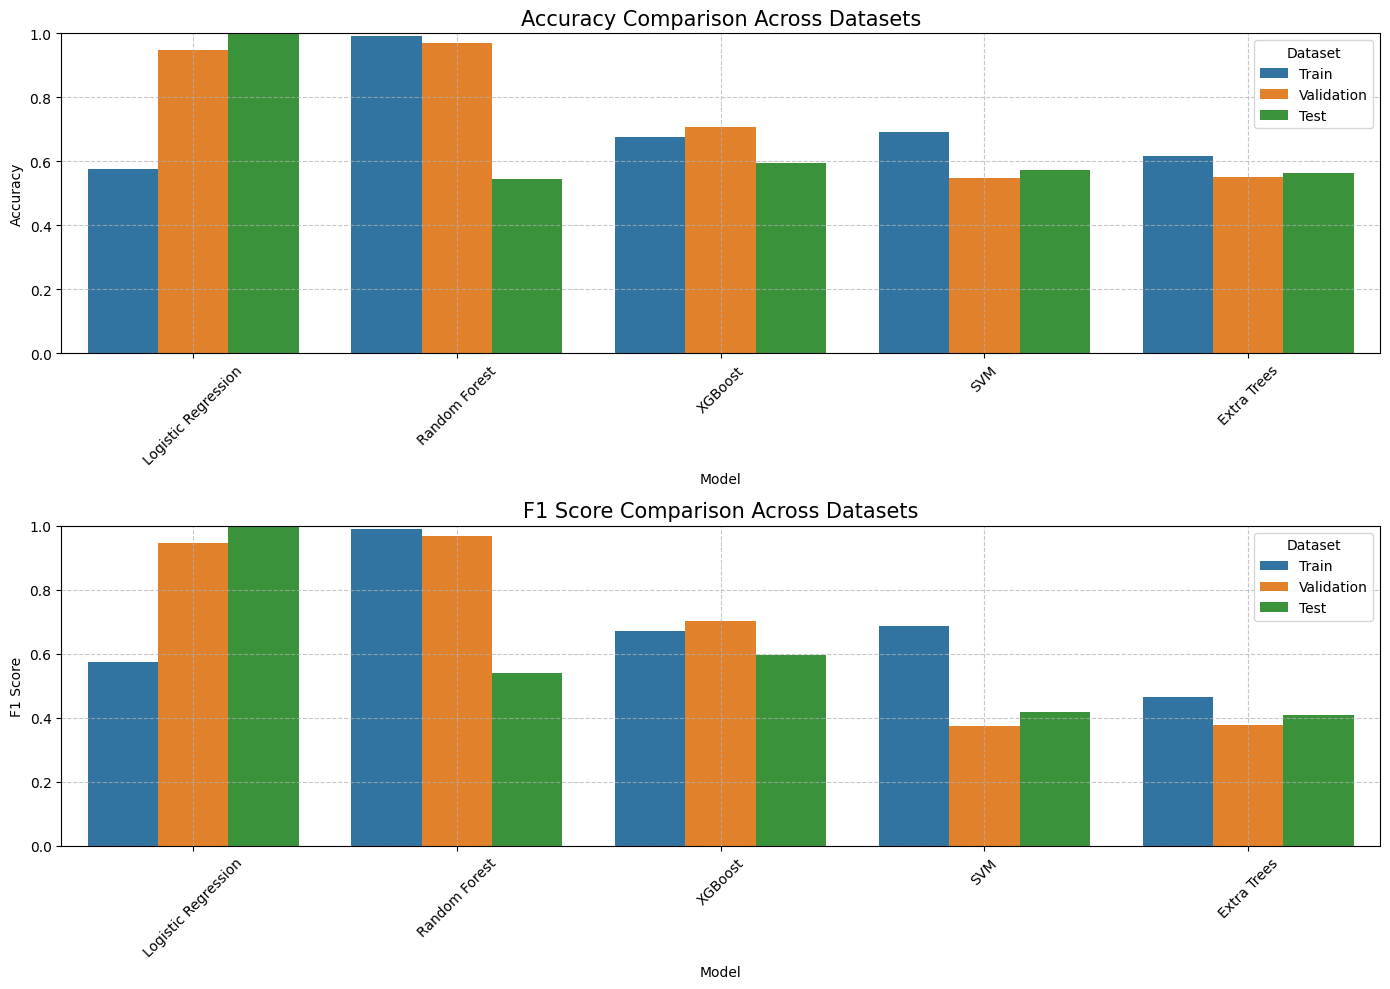

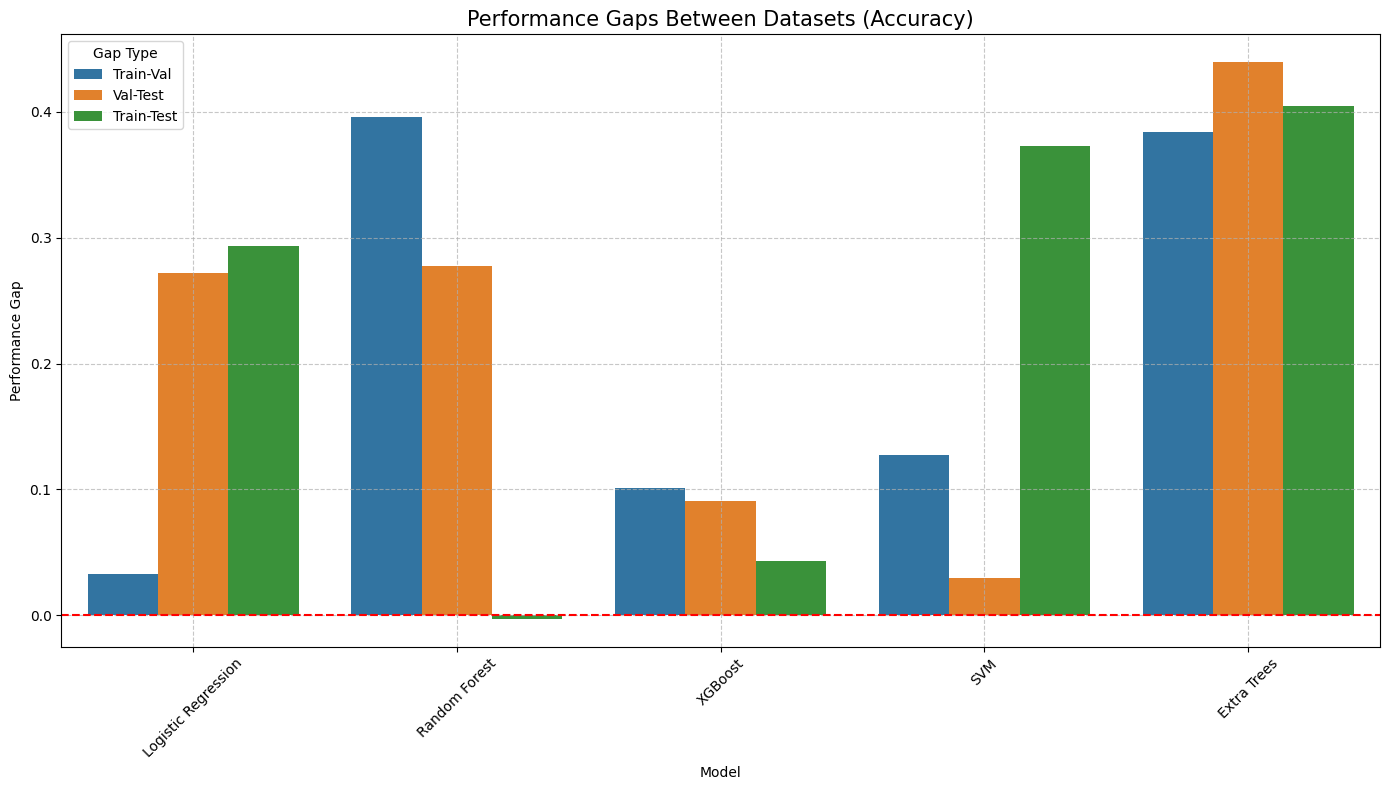


Best model based on test F1 score: XGBoost
Best model based on validation F1 score: XGBoost


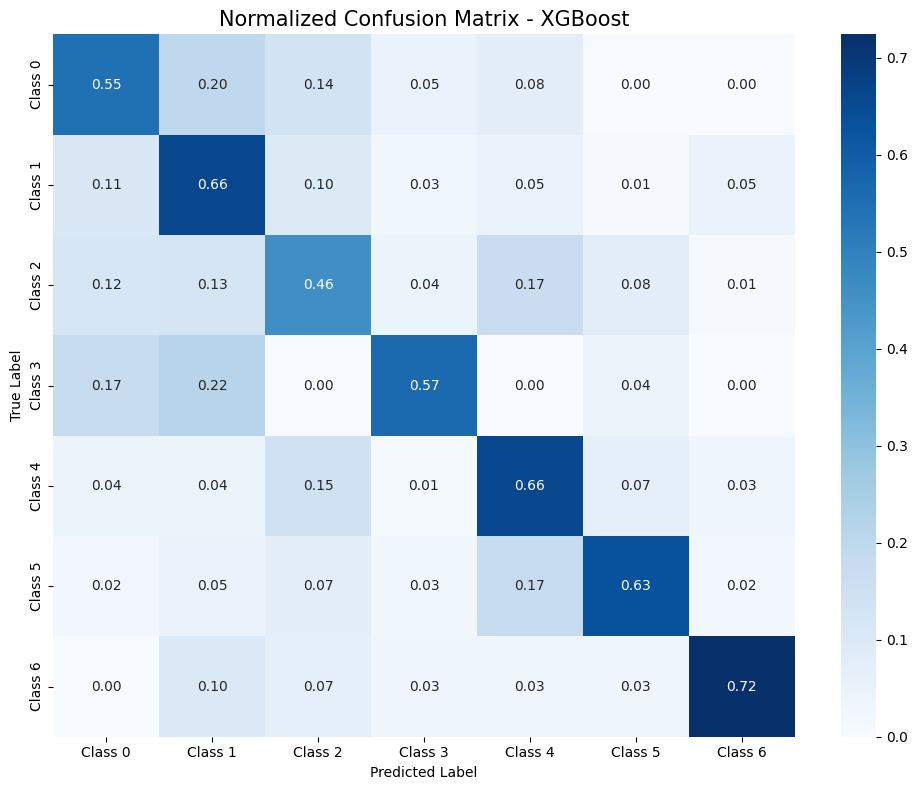

Best model saved as 'best_model_test.joblib'


In [ ]:
# CELL 16
# Three-Way Evaluation with Cross-Validation

# Load models
print("Loading models...")
lr_model = joblib.load('logistic_regression_model.joblib')
rf_model = joblib.load('random_forest_model.joblib')
xgb_model = joblib.load('xgboost_model.joblib')
svm_model = joblib.load('svm_model.joblib')
et_model = joblib.load('extra_trees_model.joblib')

# Load data
print("Loading data...")
X_train = np.load('X_train_processed.npy')
y_train = np.load('y_train.npy')

# Define models
models = [lr_model, rf_model, xgb_model, svm_model, et_model]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'Extra Trees']

print("Starting three-way evaluation...")

# 1. TRAINING METRICS
print("\n--- Calculating Training Metrics ---")
train_metrics = {
    'Model': model_names,
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

for model in models:
    y_pred = model.predict(X_train)
    train_metrics['Accuracy'].append(accuracy_score(y_train, y_pred))
    train_metrics['Precision'].append(precision_score(y_train, y_pred, average='macro'))
    train_metrics['Recall'].append(recall_score(y_train, y_pred, average='macro'))
    train_metrics['F1 Score'].append(f1_score(y_train, y_pred, average='macro'))

train_df = pd.DataFrame(train_metrics)
print("\nTraining Performance:")
print(train_df.round(4))

# 2. VALIDATION METRICS - CV
print("\n--- Calculating Validation Metrics via Cross-Validation ---")
# Define CV strategy with consistent random seed
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

val_metrics = {
    'Model': model_names,
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

for name, model in zip(model_names, models):
    print(f"Running cross-validation for {name}...")
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)

    val_metrics['Accuracy'].append(cv_results['test_accuracy'].mean())
    val_metrics['Precision'].append(cv_results['test_precision_macro'].mean())
    val_metrics['Recall'].append(cv_results['test_recall_macro'].mean())
    val_metrics['F1 Score'].append(cv_results['test_f1_macro'].mean())

val_df = pd.DataFrame(val_metrics)
print("\nValidation Performance (Cross-Validation):")
print(val_df.round(4))

##
# Load test data
print("Loading test data...")
X_test_color = np.load('X_test_color_features.npy')
X_test_texture = np.load('X_test_texture_features.npy')
X_test_shape = np.load('X_test_shape_features.npy')
y_test = np.load('y_test.npy')  # Assuming you have saved test labels

# Make sure all feature sets have same number of samples
min_test_samples = min(X_test_color.shape[0], X_test_texture.shape[0], X_test_shape.shape[0])
X_test_color = X_test_color[:min_test_samples]
X_test_texture = X_test_texture[:min_test_samples]
X_test_shape = X_test_shape[:min_test_samples]
y_test = y_test[:min_test_samples]

# Load preprocessing pipeline
preprocessing_pipeline = joblib.load('preprocessing_pipeline.joblib')

# Process test data using same pipeline as training data
X_test_processed = process_test_val_data(X_test_color, X_test_texture, X_test_shape, preprocessing_pipeline)
print(f"Processed test data shape: {X_test_processed.shape}")
##


# 3. TEST METRICS
print("\n--- Calculating Test Metrics ---")
test_metrics = {
    'Model': model_names,
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

for model in models:
    y_pred = model.predict(X_test_processed)
    test_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    test_metrics['Precision'].append(precision_score(y_test, y_pred, average='macro'))
    test_metrics['Recall'].append(recall_score(y_test, y_pred, average='macro'))
    test_metrics['F1 Score'].append(f1_score(y_test, y_pred, average='macro'))

test_df = pd.DataFrame(test_metrics)
print("\nTest Performance:")
print(test_df.round(4))

# 4. THREE-WAY COMPARISON
print("\n--- Three-Way Performance Comparison ---")

# Comprehensive comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Train Accuracy': train_df['Accuracy'],
    'Val Accuracy': val_df['Accuracy'],
    'Test Accuracy': test_df['Accuracy'],
    'Train F1': train_df['F1 Score'],
    'Val F1': val_df['F1 Score'],
    'Test F1': test_df['F1 Score'],
    'Train-Val Gap': train_df['Accuracy'] - val_df['Accuracy'],
    'Val-Test Gap': val_df['Accuracy'] - test_df['Accuracy'],
    'Train-Test Gap': train_df['Accuracy'] - test_df['Accuracy']
}).round(4)

print(comparison_df)

# 5. VISUALIZATIONS
# Three-way accuracy comparison
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
acc_data = pd.DataFrame({
    'Model': np.repeat(model_names, 3),
    'Dataset': np.tile(['Train', 'Validation', 'Test'], len(model_names)),
    'Accuracy': np.concatenate([
        train_df['Accuracy'],
        val_df['Accuracy'],
        test_df['Accuracy']
    ])
})
sns.barplot(x='Model', y='Accuracy', hue='Dataset', data=acc_data)
plt.title('Accuracy Comparison Across Datasets', fontsize=15)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Three-way F1 score comparison
plt.subplot(2, 1, 2)
f1_data = pd.DataFrame({
    'Model': np.repeat(model_names, 3),
    'Dataset': np.tile(['Train', 'Validation', 'Test'], len(model_names)),
    'F1 Score': np.concatenate([
        train_df['F1 Score'],
        val_df['F1 Score'],
        test_df['F1 Score']
    ])
})
sns.barplot(x='Model', y='F1 Score', hue='Dataset', data=f1_data)
plt.title('F1 Score Comparison Across Datasets', fontsize=15)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Performance gaps visualization
plt.figure(figsize=(14, 8))
gap_data = pd.DataFrame({
    'Model': np.repeat(model_names, 3),
    'Gap Type': np.tile(['Train-Val', 'Val-Test', 'Train-Test'], len(model_names)),
    'Performance Gap': np.concatenate([
        comparison_df['Train-Val Gap'],
        comparison_df['Val-Test Gap'],
        comparison_df['Train-Test Gap']
    ])
})
sns.barplot(x='Model', y='Performance Gap', hue='Gap Type', data=gap_data)
plt.title('Performance Gaps Between Datasets (Accuracy)', fontsize=15)
plt.axhline(y=0, color='r', linestyle='--', label='No Gap')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Identify best model based on test F1 score
best_test_idx = test_df['F1 Score'].idxmax()
best_test_model = model_names[best_test_idx]
print(f"\nBest model based on test F1 score: {best_test_model}")

# Identify best model based on validation F1 score
best_val_idx = val_df['F1 Score'].idxmax()
best_val_model = model_names[best_val_idx]
print(f"Best model based on validation F1 score: {best_val_model}")

# Confusion matrix for best test model
plt.figure(figsize=(10, 8))
best_model = models[best_test_idx]
y_pred = best_model.predict(X_test_processed)
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_names = [f'Class {j}' for j in range(len(np.unique(y_test)))]

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Normalized Confusion Matrix - {best_test_model}', fontsize=15)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Save the best model
joblib.dump(best_model, 'best_model_test.joblib')
print(f"Best model saved as 'best_model_test.joblib'")